### Analysis for du Plessis -  High-frequency variations of the mixed layer buoyancy in the Southern Ocean

This notebook is the code used to plot the figures du Plessis et al - JGR Oceans

The code is run in the following order:

#### Load the dependencies

In [1]:
%pylab inline
import xarray as xr
from tqdm import tqdm_notebook
import cmocean.cm as cmo
import pandas as pd

import my_functions as my

plt.rcParams['figure.figsize'] = (18,10)
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 13}

matplotlib.rc('font', **font)

rc('ytick.major', size=7)
rc('xtick.major', size=7)
rc('ytick.minor', size=5)
rc('xtick.minor', size=5)
rc('lines', linewidth=1.5)

Populating the interactive namespace from numpy and matplotlib


Define colors

In [2]:
lightblue = '#5499c7'
blue      = '#21618c'
orange    = '#f39c12'
green     = '#27ae60'
red       = '#cb4335'

Date format

In [3]:
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator(interval=1)  # every month
week = mdates.WeekdayLocator(byweekday=mdates.MO, interval=1)
weeks = mdates.WeekdayLocator(byweekday=mdates.MO, interval=3)

yearsFmt = mdates.DateFormatter("%d/%m")

mnthFmt = mdates.DateFormatter("%B")

Make a small function to calculate the rolling mean

In [4]:
def rolling_mean(dat, window=4):
    
    dat_new = gt.cleaning.rolling_window(dat, func=np.mean, window=window)
    
    return dat_new

#### Load the glider data

In [5]:
import glidertools as gt
import xarray as xr
import numpy as np

dat_saz = xr.open_dataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/sg542_saz_L2.nc')
dat_apz = xr.open_dataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/slocum_apz_L2.nc')
dat_miz = xr.open_dataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/sg643_miz_L2.nc')

# interpolate to a resolution of 6 hours

interp_res = '6H'
offset     = '3H'
dt=21600

dat_saz_interp = dat_saz.resample(time=interp_res, loffset=offset).mean()
dat_apz_interp = dat_apz.resample(time=interp_res, loffset=offset).mean()
dat_miz_interp = dat_miz.resample(time=interp_res, loffset=offset).mean()

dat_saz_interp=dat_saz_interp.interpolate_na(dim='time')
dat_apz_interp=dat_apz_interp.interpolate_na(dim='time')
dat_miz_interp=dat_miz_interp.interpolate_na(dim='time')

# calculate the mixed layer depth 

import my_functions as my

for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):
    
    dat['mld_03'] = (('time'), my.calc_mld(dat.density, dat.depth, den_lim=0.03))


# calculate the mixed layer temperature and salinity 

for dat in [dat_saz_interp, dat_apz_interp, dat_miz_interp]:

    xt=[]
    xs=[]
    
    for i, m in enumerate(np.round(dat['mld_03'].astype(int))):
        
        xt += dat.temp.sel(depth=slice(5, m-5)).mean(dim='depth').values[i],
        xs += dat.salt.sel(depth=slice(5, m-5)).mean(dim='depth').values[i],
    
    dat['ml_s'] = (('time'), xs)
    dat['ml_t'] = (('time'), xt)
    
    dat['ml_s_smooth'] = (('time'), gt.cleaning.rolling_window(dat['ml_s'], func=np.nanmean, window=6))
    dat['ml_t_smooth'] = (('time'), gt.cleaning.rolling_window(dat['ml_t'], func=np.nanmean, window=6))

### Figure 2: Glider sampling strategies

Plot the varying glider sampling strategies. First step is we plot the geo location of the glider profiles

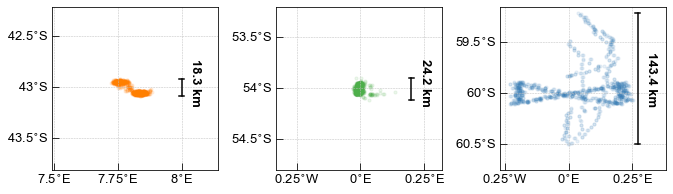

In [6]:
import gsw

fig,ax=subplots(1,3,figsize=[11,3])

fig.subplots_adjust(wspace=0.35)

clrs = ['#ff7f00', '#4daf4a', '#377eb8']

for i, dat in enumerate([dat_saz, dat_apz, dat_miz]):

    ax[i].scatter(dat.lon,dat.lat, c=clrs[i], s=10, alpha=0.1)
    
    ax[i].set_xlim(dat.lon.median()-0.325,                   
                   dat.lon.median()+0.325
                  )
    
    ax[i].set_ylim(dat.lat.mean()-0.8,
                   dat.lat.mean()+0.8
                  )
    
    ax[i].grid(lw=0.5, c='0.75', ls='--')
    
    
    # plot the scales
    
    x = [8, 0.2, 0.27]
    
    ax[i].plot([x[i], x[i]],
               [dat.lat.min(), dat.lat.max()],
               c='k', lw=1.5
              )
    
    ax[i].plot([x[i]+0.01, x[i]-0.01],
           [dat.lat.min(), dat.lat.min()],
           c='k', lw=1.5
          )
    
    ax[i].plot([x[i]+0.01, x[i]-0.01],
           [dat.lat.max(), dat.lat.max()],
           c='k', lw=1.5
          )
    
    # get the distance of the north-south movements
    d = gsw.distance([dat.lon.mean()+0.275, dat.lon.mean()+0.25],
                     [dat.lat.min(), dat.lat.max()]
                    )[0] / 1000
    
    ax[i].text(x[i]+0.03, 
               dat.lat.mean()-0.15, 
               str(np.round(d, 1))+' km',
               rotation=-90,
               fontweight='bold'
              )

ax[0].xaxis.set_ticks([7.5, 7.75, 8])
ax[0].xaxis.set_ticklabels(['7.5$^{\circ}$E', '7.75$^{\circ}$E', '8$^{\circ}$E'])

ax[0].yaxis.set_ticks([-43.5, -43, -42.5])
ax[0].yaxis.set_ticklabels(['43.5$^{\circ}$S', '43$^{\circ}$S', '42.5$^{\circ}$S'])

ax[1].xaxis.set_ticks([-0.25, 0, 0.25])
ax[1].xaxis.set_ticklabels(['0.25$^{\circ}$W', '0$^{\circ}$E', '0.25$^{\circ}$E'])

ax[1].yaxis.set_ticks([-54.5, -54, -53.5])
ax[1].yaxis.set_ticklabels(['54.5$^{\circ}$S', '54$^{\circ}$S', '53.5$^{\circ}$S'])

ax[2].xaxis.set_ticks([-0.25, 0, 0.25])
ax[2].xaxis.set_ticklabels(['0.25$^{\circ}$W', '0$^{\circ}$E', '0.25$^{\circ}$E'])

ax[2].yaxis.set_ticks([-60.5, -60, -59.5])
ax[2].yaxis.set_ticklabels(['60.5$^{\circ}$S', '60$^{\circ}$S', '59.5$^{\circ}$S'])

savefig('../../figures/glider_sampling.png', dpi=300, bbox_inches='tight')

Next we plot the latitudinal movement of the glider with respect to their latitudinal mean and as a function of distance

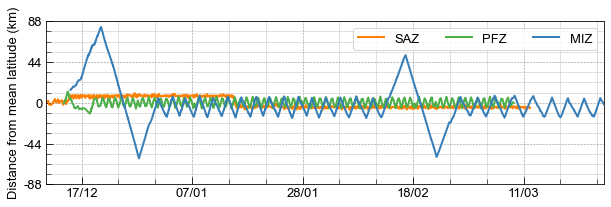

In [7]:
fig,ax=subplots(figsize=[10,3])

clrs = ['#ff7f00', '#4daf4a', '#377eb8']
name = ['SAZ', 'PFZ', 'MIZ']

for i, dat in enumerate([dat_saz, dat_apz, dat_miz]):
    
    ax.plot(dat.time, 
            dat.lat-dat.lat.mean(), # mean latitude of the gliders
            c=clrs[i],
            label=name[i],
            lw=2
           )
    
ax.yaxis.set_ticks(np.arange(-0.8, 1.2, 0.1), minor=True)
ax.yaxis.set_ticks(np.arange(-0.8, 1.2, 0.1), minor=True)

ax.grid(c='0.6', lw=0.6, ls='--')
ax.grid(which='minor', lw=0.6, c='0.8')

d=gsw.distance([0, 0],
               [-60,-60.4]
              )[0] / 1000

d=int(np.round(d,0))

ax.yaxis.set_ticks(np.arange(-0.8, 1.2, 0.4))
ax.yaxis.set_ticklabels([-d*2, -d, 0, d, d*2])

ax.legend(ncol=3)

ax.xaxis.set_major_locator(weeks)
ax.xaxis.set_minor_locator(week)
ax.xaxis.set_major_formatter(yearsFmt)

ax.set_ylabel('Distance from mean latitude (km)')

ax.set_ylim(-0.8, 0.8)

ax.set_xlim(dat_saz.time.values[0], dat_miz.time.values[-1])

savefig('../../figures/glider_sampling_latitudes.png', dpi=300, bbox_inches='tight')

Finally, we plot the spatial and temporal resolution of glider profiles

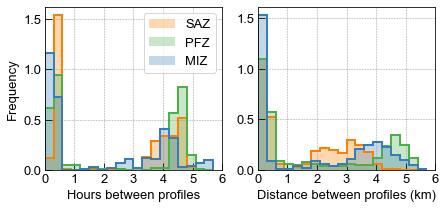

In [8]:
fig,ax=subplots(1,2,figsize=[7, 3])

for i, dat in enumerate([dat_saz, dat_apz, dat_miz]):
    
    t = np.diff(date2num(dat.time.values))*24
    
    ax[0].hist(t, 
               bins=np.arange(0, 6, 0.3),
               histtype='bar',
               alpha=0.3,
               facecolor=clrs[i],
               density=True,
               label=name[i]
              )
    
    ax[0].hist(t, 
               bins=np.arange(0, 6, 0.3),
               histtype='step',
               lw=2,
               edgecolor=clrs[i],
               density=True
              )
    
    ax[0].xaxis.set_ticks(np.arange(0, 7, 1))
    ax[0].grid(lw=0.5, c='0.6', ls='--')
    ax[0].set_xlabel('Hours between profiles')
    ax[0].set_xlim(0, 6)
    ax[0].set_ylabel('Frequency')
    ax[0].legend()
    
    
    # distance between profiles
    
    d = gsw.distance(dat.lon.values, dat.lat.values)/1000
    
    ax[1].hist(d, 
           bins=np.arange(0, 6, 0.3),
           histtype='bar',
           alpha=0.3,
           facecolor=clrs[i],
           density=True
          )
    
    ax[1].hist(d, 
               bins=np.arange(0, 6, 0.3),
               histtype='step',
               lw=2,
               edgecolor=clrs[i],
               density=True
              )
    
    ax[1].xaxis.set_ticks(np.arange(0, 7, 1))
    ax[1].grid(lw=0.5, c='0.6', ls='--')
    ax[1].set_xlabel('Distance between profiles (km)')
    ax[1].set_xlim(0, 6)

    savefig('../../figures/glider_sampling_histograms.png', dpi=300, bbox_inches='tight')

Calculate and show the mean distance and time for each glider

In [9]:
for i, dat in enumerate([dat_saz, dat_apz, dat_miz]):

    d = gsw.distance(dat.lon.values, dat.lat.values)/1000
    t = np.diff(date2num(dat.time.values))*24
    
    print('distance ' + str(np.mean(d)))
    print('time ' + str(np.mean(t)))
    print('')

distance 1.563514257082447
time 2.2926280719972096

distance 2.023977610925672
time 2.45615435795068

distance 1.9573102830708058
time 2.4866964894341894



### Figure Supp

Comparison between raw and smoothed glider mixed layer T/S 

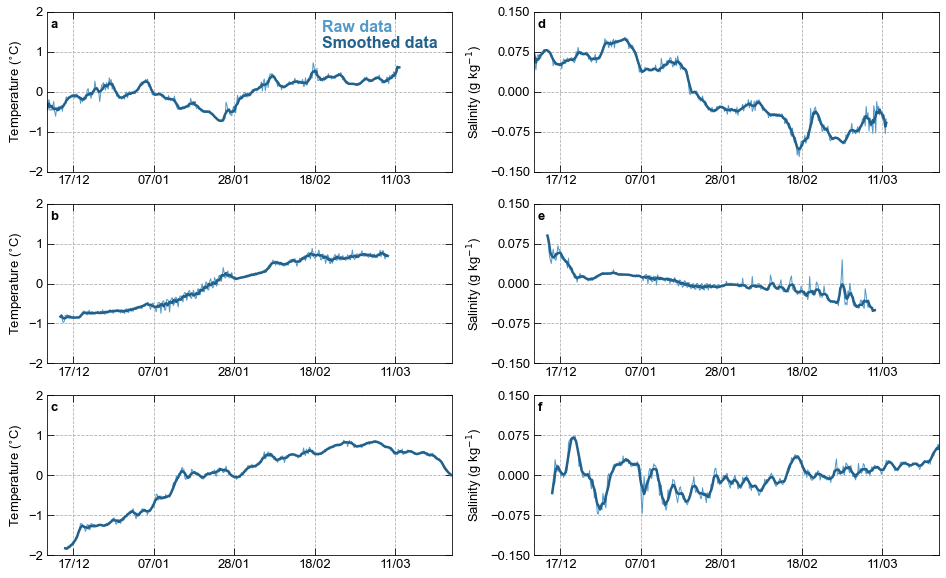

In [10]:
fig,ax=subplots(3,2,figsize=[16, 10])

for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):
    
    ax[i,0].plot(dat.time, dat.ml_t        - np.mean(dat.ml_t)       , c=lightblue, lw=1)
    ax[i,0].plot(dat.time, dat.ml_t_smooth - np.mean(dat.ml_t_smooth), c=blue,      lw=2.5)
    
    ax[i,1].plot(dat.time, dat.ml_s        - np.mean(dat.ml_s)       , c=lightblue, lw=1)
    ax[i,1].plot(dat.time, dat.ml_s_smooth - np.mean(dat.ml_s_smooth), c=blue,      lw=2.5)
    
    ax[i,0].set_ylabel('Temperature ($^{\circ}$C)')
    ax[i,1].set_ylabel('Salinity (g kg$^{-1}$)', labelpad=5)
    
    ax[i,0].set_ylim(-2, 2)
    ax[i,1].set_ylim(-0.15, 0.15)
    
    ax[i,1].yaxis.set_ticks(np.arange(-0.15, 0.225, 0.075))
    
    for j in range(2):
        
        ax[i,j].grid(ls='--', which='major', axis='both')        
        ax[i,j].set_xlim(pd.to_datetime('2018-12-10'), pd.to_datetime('2019-03-26'))

        ax[i,j].xaxis.set_major_locator(weeks)
        ax[i,j].xaxis.set_major_formatter(yearsFmt)

        ax[i,j].yaxis.set_ticks_position('both')
        ax[i,j].xaxis.set_ticks_position('both')
    
ax[0,0].text(pd.to_datetime('2019-02-20'), 1.5, 'Raw data',      c=lightblue, fontweight='bold', fontsize=16)
ax[0,0].text(pd.to_datetime('2019-02-20'), 1.1, 'Smoothed data', c=blue,      fontweight='bold', fontsize=16)

ax[0,0].text(pd.to_datetime('2018-12-11'), 1.6, 'a', fontweight='bold')
ax[1,0].text(pd.to_datetime('2018-12-11'), 1.6, 'b', fontweight='bold')
ax[2,0].text(pd.to_datetime('2018-12-11'), 1.6, 'c', fontweight='bold')

ax[0,1].text(pd.to_datetime('2018-12-11'), 0.12, 'd', fontweight='bold')
ax[1,1].text(pd.to_datetime('2018-12-11'), 0.12, 'e', fontweight='bold')
ax[2,1].text(pd.to_datetime('2018-12-11'), 0.12, 'f', fontweight='bold')

savefig('../../figures/Fig_Supp_raw_smooth_glider_ML_TS.png', dpi=300, bbox_inches='tight')

### Figure Supp

Show all mixed layer density profiles and the mean profile with the MLD

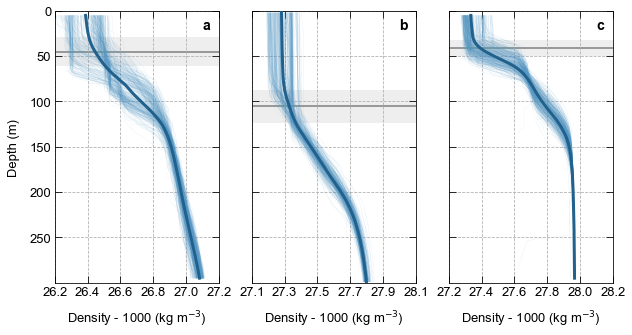

In [11]:
from collections import OrderedDict

fig,ax=subplots(1,3, figsize=[10,5], sharey=True)

for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):

    [ax[i].plot(dat.density.isel(time=t)-1000, dat.depth, lw=0.2, c=lightblue, alpha=0.25, label='Glider density') for t in range(len(dat.time))]
    
    ax[i].set_ylim(300, 0)
    ax[i].set_xlabel('Density - 1000 (kg m$^{-3}$)', labelpad=10)
    ax[i].yaxis.set_ticks_position('both')
    ax[i].xaxis.set_ticks_position('both')
    
    ax[i].plot(dat.density.mean(dim='time')-1000, dat.depth, c=blue, lw=3, label='Glider mean density', zorder=10)

    mld_mean = dat.mld_03.mean(dim='time')
    mld_std  = dat.mld_03.std(dim='time')
    
    ax[i].grid(ls='--', which='major', axis='both') 
    
    ax[i].plot([26, 28.6], [mld_mean, mld_mean], c='0.6', lw=2, ls='-', label='MLD', zorder=1)
    ax[i].fill_between(x=[26, 28.6], y1=mld_mean-mld_std, y2=mld_mean+mld_std, facecolor='0.75', alpha=0.25, label='MLD $\sigma$', zorder=0)

ax[0].set_xlim(26.2, 27.2)
ax[1].set_xlim(27.1, 28.1)
ax[2].set_xlim(27.2, 28.2)

ax[0].xaxis.set_ticks(np.arange(26.2, 27.4, 0.2))
ax[1].xaxis.set_ticks(np.arange(27.1, 28.3, 0.2))
ax[2].xaxis.set_ticks(np.arange(27.2, 28.4, 0.2))

ax[0].yaxis.set_ticks([250, 200, 150, 100, 50, 0])

ax[0].set_ylabel('Depth (m)', labelpad=10)

# ax[0].set_title('Subantarctic Zone')
# ax[1].set_title('Polar Frontal Zone')
# ax[2].set_title('Marginal Ice Zone')

ax[0].text(27.1, 20, 'a', fontweight='bold', fontsize=14)
ax[1].text(28.0, 20, 'b', fontweight='bold', fontsize=14)
ax[2].text(28.1, 20, 'c', fontweight='bold', fontsize=14)

# ax[1].text(27.45, 93, 'Mixed layer depth', c='0.5', fontsize=14, fontweight='bold')

savefig('../../figures/Fig_Supp_den_profiles.png', dpi=300, bbox_inches='tight')

### Figure 4
---

### Atmospheric forcing terms

#### Load air-sea fluxes of heat and freshwater

In [12]:
era5 = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/ERA5_flux_data/*.nc')
era5 = era5.sel(latitude=slice(-40, -65), longitude=slice(-5, 10))

#### Convert from J m$^{-2}$ to W m$^{-2}$

In [13]:
var_name=['slhf', 'sshf', 'str', 'ssr', 'tp', 'e']
era5=my.convert_era5_to_Wm2(ds=era5, var_name=var_name)

#### Calculate the net surface heat flux and evaporation minus precipitation

In [14]:
era5['emp']  = (('time', 'latitude', 'longitude'), era5['e']-era5['tp'])
era5['qnet'] = (('time', 'latitude', 'longitude'), era5['slhf']+era5['sshf']+era5['str' ]+era5['ssr' ])

#### Interpolate to the glider resolution

In [15]:
era5_interp = era5.resample(time=interp_res, loffset=offset).mean()

#### Co-locate air-sea fluxes to glider location

In [16]:
from tqdm import tqdm

var_name = ['slhf','sshf','str' ,'ssr' ,'tp' ,'e' ,'emp' , 'u10', 'v10', 'qnet']  

for var in tqdm(var_name):
    
    dat_saz_interp[var] = (('time'), my.interp_glider_era5(dat_saz_interp, era5_interp, var=var))
    dat_apz_interp[var] = (('time'), my.interp_glider_era5(dat_apz_interp, era5_interp, var=var))
    dat_miz_interp[var] = (('time'), my.interp_glider_era5(dat_miz_interp, era5_interp, var=var))

100%|██████████| 10/10 [01:53<00:00, 11.31s/it]


#### Calculate wind stress

In [17]:
import airsea

for dat in [dat_saz_interp, dat_apz_interp, dat_miz_interp]:
    
    dat['taux'] = (('time'), airsea.windstress.stress(dat.u10, z=10., drag='largepond'))
    dat['tauy'] = (('time'), airsea.windstress.stress(dat.v10, z=10., drag='largepond'))
    
    dat['tau']    = (('time'), np.sqrt(dat['taux']**2 + dat['tauy']**2))

Set some font parameters

In [18]:
font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 13}

matplotlib.rc('font', **font)

Set some functions to calculate the wind direction so we can plot the wind roses for each region

In [19]:
def getWindDir(uwind, vwind):
    
    data_dir = []
    
    for i in range(len(uwind)):
        
        data_dir += math.atan2(vwind[i], uwind[i])/math.pi*180,

    data_dir = array(data_dir)
    
    return data_dir

In [20]:
def setWindDirZero360(wind_dir):

    ind1 = numpy.nonzero((wind_dir > 0)    & (wind_dir < 90))
    ind2 = numpy.nonzero((wind_dir > 90)   & (wind_dir < 190))
    ind3 = numpy.nonzero((wind_dir > -180) & (wind_dir < -90))
    ind4 = numpy.nonzero((wind_dir > -90)  & (wind_dir < 0))
    
    wind_dir[ind1] = 90 - wind_dir[ind1]
    wind_dir[ind2] = 450 - wind_dir[ind2]
    wind_dir[ind3] = abs(wind_dir[ind3] - 90)
    wind_dir[ind4] = abs(wind_dir[ind4]) + 90
    
    return wind_dir

Calculate wind direction from u10 and v10

In [21]:
for w, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):

    dat['wind_dir'] = getWindDir(dat['u10'], dat['v10'])
    dat['wind_dir'] = setWindDirZero360(dat['wind_dir'].values)


First, we plot the wind roses for each region

/Users/marcel/opt/anaconda3/lib/python3.8/site-packages/windrose/windrose.py:572: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = mpl.patches.Rectangle(
/Users/marcel/opt/anaconda3/lib/python3.8/site-packages/windrose/windrose.py:572: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = mpl.patches.Rectangle(
/Users/marcel/opt/anaconda3/lib/python3.8/site-packages/windrose/windrose.py:572: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = mpl.patches.Rectangle(


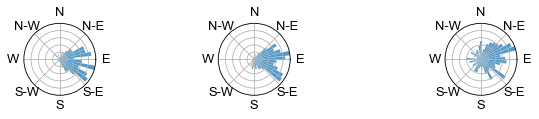

In [22]:
from windrose import WindroseAxes

fig = figure(figsize=[9, 4])

## Plot wind rose of the current directions for soscex 1 

# add rectangles for each subplot
rect1=[0.05,0.05,0.25,0.25] 
rect2=[0.35,0.05,0.25,0.25] 
rect3=[0.70,0.05,0.25,0.25] 

# add axes to be plotted on
w1=WindroseAxes(fig, rect1)
w2=WindroseAxes(fig, rect2)
w3=WindroseAxes(fig, rect3)

ws = [w1, w2, w3]

for w, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):

    fig.add_axes(ws[w])
    
    ws[w].bar(dat['wind_dir'], dat['tau']*0, 
              bins=1, 
              lw=0, 
              color=lightblue, 
              opening=0.9, 
              nsector=45, 
              normed=True, 
              zorder=100)
    
    ws[w].yaxis.set_ticklabels([])


savefig('/Users/Marcel/Google Drive/Projects/buoyancy_flux_paper/figures/wind_rose.png', dpi=400)

In [24]:
dat_saz_1D = dat_saz_interp.resample(time='1D', loffset='12H').mean()
dat_apz_1D = dat_apz_interp.resample(time='1D', loffset='12H').mean()
dat_miz_1D = dat_miz_interp.resample(time='1D', loffset='12H').mean()

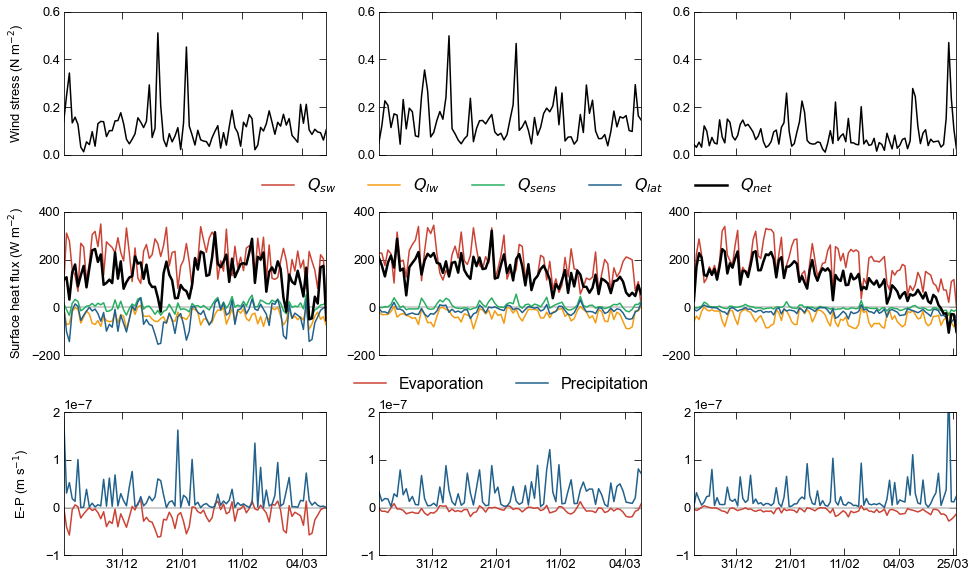

In [57]:
fig,ax=subplots(3,3, figsize=[16, 10]) 


fig.subplots_adjust(hspace=0.4)

for r, dat in enumerate([dat_saz_1D, dat_apz_1D, dat_miz_1D]):
    
    for c, var in enumerate(['tau', 'qnet', 'emp']):
        
        if c==0:
            ax[c, r].plot(dat.time.values, dat[var], lw=1.5, label=r'$\tau$', c='k')
                        
        if c==1:
            ax[c, r].hlines(0, dat.time.values[0], dat.time.values[-1], color='0.75')
            ax[c, r].plot(dat.time.values, dat['ssr'],  lw=1.5, label='$Q_{sw}$'  , color=red)
            ax[c, r].plot(dat.time.values, dat['str'],  lw=1.5, label='$Q_{lw}$'  , color=orange)
            ax[c, r].plot(dat.time.values, dat['sshf'], lw=1.5, label='$Q_{sens}$', color=green)
            ax[c, r].plot(dat.time.values, dat['slhf'], lw=1.5, label='$Q_{lat}$' , color=blue)
            ax[c, r].plot(dat.time.values, dat[var],    lw=2.5, label='$Q_{net}$' , c='k')
            
        if c==2:
            ax[c, r].hlines(0, dat.time.values[0], dat.time.values[-1], color='0.75')
            ax[c, r].plot(dat.time.values, dat['e'],  lw=1.5, c=red,  label='Evaporation')
            ax[c, r].plot(dat.time.values, dat['tp'], lw=1.5, c=blue, label='Precipitation')

        ax[0, c].set_ylim(0, 0.6)
        ax[1, c].set_ylim(-200, 400)
        ax[2, c].set_ylim(-1e-7, 2e-7)
        
        ax[r,c].xaxis.set_major_locator(weeks)
        ax[r,c].xaxis.set_major_formatter(yearsFmt)

        ax[c,r].yaxis.set_ticks_position('both')
        ax[c,r].xaxis.set_ticks_position('both')
        
        ax[c,r].set_xlim(dat.time.values[0], dat.time.values[-1])
        
    for r in range(2):
        for c in range(3):
            ax[r,c].xaxis.set_ticklabels([])
        
ax[1,0].legend(frameon=False, loc=2, ncol=5, bbox_to_anchor=(0.7, 1.35), fontsize=16)
ax[2,0].legend(frameon=False, loc=2, ncol=2, bbox_to_anchor=(1.05, 1.35), fontsize=16)

# ylabels
ax[0,0].set_ylabel('Wind stress (N m$^{-2}$)', labelpad=15)
ax[1,0].set_ylabel('Surface heat flux (W m$^{-2}$)')
ax[2,0].set_ylabel('E-P (m s$^{-1}$)', labelpad=13)

savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/Final Figures/Fig_4_atm_vars.png', dpi=300)

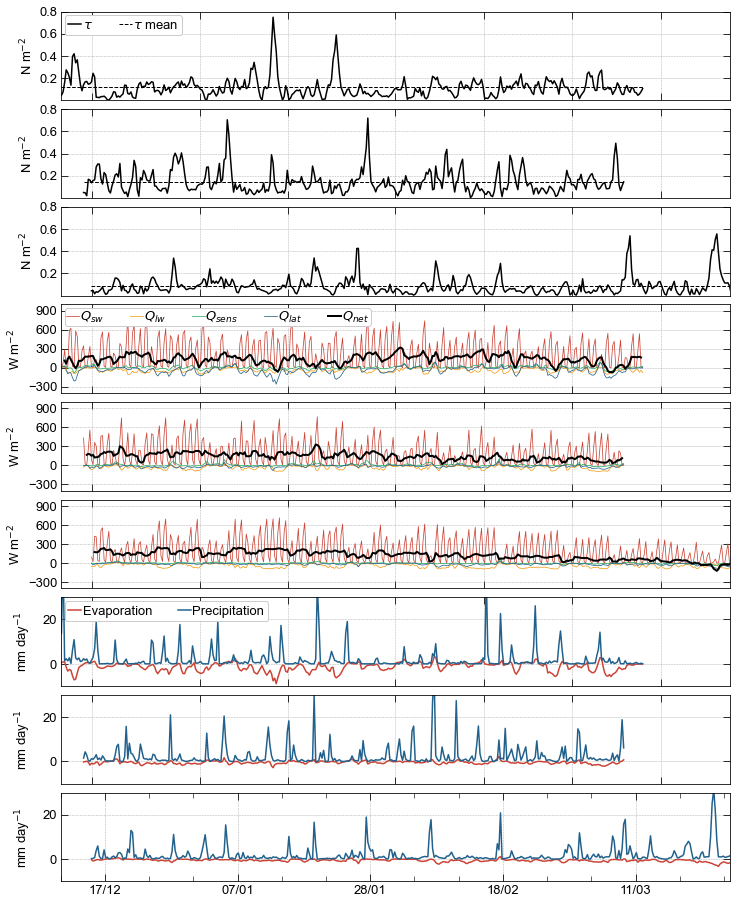

In [58]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12,16))
gs = gridspec.GridSpec(nrows=9,ncols=5, hspace=0.1, wspace=0.1)  # sets a grid of 6 rows by 4 column

l=-1

for r in range(3):       
        
    for c, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):    
            
        if r==0: # winds 
            
            ax = fig.add_subplot(gs[c,:5]) 

            ax.plot(dat.time, dat['tau'], c='k', label=r'$\tau$', lw=1.5)
            ax.hlines(y=dat['tau'].mean(), xmin=dat.time[0].values, xmax=dat.time[-1].values, color='k', label=r'$\tau$ mean', lw=1, ls='--')
            
            ax.set_ylim(0, 0.8)
            ax.yaxis.set_ticks([0.2, 0.4, 0.6, 0.8])            
            ax.set_ylabel('N m$^{-2}$')
            
            
            if c==0:
                ax.legend(framealpha=1, loc=2, handlelength=1, handletextpad=0.1, ncol=5, borderpad=0.3, borderaxespad=0.3)
            
        if r==1:
            
            ax = fig.add_subplot(gs[3+c,:5]) 
            
            ax.plot(dat.time, dat['ssr'],  lw=0.75, label='$Q_{sw}$'  , color=red)
            ax.plot(dat.time, dat['str'],  lw=0.75, label='$Q_{lw}$'  , color=orange)
            ax.plot(dat.time, dat['sshf'], lw=0.75, label='$Q_{sens}$', color=green)
            ax.plot(dat.time, dat['slhf'], lw=0.75, label='$Q_{lat}$' , color=blue)
            ax.plot(dat.time, dat['qnet'].rolling(time=4, center=True).mean(), lw=2, label='$Q_{net}$',  c='k')
            
            ax.set_ylim(-400, 1000)
            ax.yaxis.set_ticks(np.arange(-300, 1200, 300))
            ax.set_ylabel('W m$^{-2}$')
            
            if c==0:
                ax.legend(framealpha=1, loc=2, handlelength=1, handletextpad=0.05, labelspacing=0.1, ncol=5, borderpad=0.1, borderaxespad=0.3)
            
        if r==2:            
            
            ax = fig.add_subplot(gs[6+c,:5])
            
            ax.plot(dat.time, dat['e'] *(86400*1000), c=red,  label='Evaporation',   lw=1.5)
            ax.plot(dat.time, dat['tp']*(86400*1000), c=blue, label='Precipitation', lw=1.5) 
            
            ax.set_ylim(-10, 30) 
            ax.set_ylabel('mm day$^{-1}$', labelpad=10)

            if c==0:
                ax.legend(framealpha=1, loc=2, handlelength=1, handletextpad=0.1, labelspacing=0.2, ncol=5, borderpad=0.3, borderaxespad=0.3)
            
        ax.grid(ls='--', which='major', axis='both', lw=0.5)        
        ax.set_xlim(pd.to_datetime('2018-12-10'), pd.to_datetime('2019-03-26'))
        
        
        if r==2 and c==2:
                
            ax.xaxis.set_major_locator(weeks)
            ax.xaxis.set_minor_locator(week)
            ax.xaxis.set_major_formatter(yearsFmt)
                
        else: 
            
            ax.xaxis.set_ticklabels([])
            
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')
        
    
    
savefig('../../figures/forcing_terms.png', dpi=300, bbox_inches='tight')

Calculate the inertial periods for each site

In [59]:
import gsw
print(((2*math.pi)/gsw.f(-43.5))/60/60)
print(((2*math.pi)/gsw.f(-54))/60/60)
print(((2*math.pi)/gsw.f(-60))/60/60)

-17.38527878244804
-14.792317445513763
-13.818574082600925


### Figure 5
#### Plot the figure showing gradients of the mixed layer from the TSG, EN4 and Sailbuoy data
---

Lateral temperature and salinity gradients from the TSG

#### Load the TSG data

In [60]:
tsg_new = pd.read_csv('tsg_df.csv')
tsg = tsg_new.set_index(['date'])
tsg = tsg.to_xarray()

What is the mean and standard deviation of the TSG resolution

In [61]:
d = gsw.distance(tsg.Longitude.values, tsg.Latitude.values)
print(mean(d))
print(std(d))

28.49701329027484
55.83417236120179


#### Load the EN4.2.1 dataset

In [62]:
# Load the data
EN4 = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/so_chic_prep/EN4/optimal_interpolation/*.nc')

EN4 = EN4.sel(depth=EN4.depth[0].values)
EN4 = my.adjust_lon_xr_dataset(EN4, lon_name='lon')

# select the months between  
idx = ((EN4.time.dt.month > 11) | (EN4.time.dt.month < 4))
EN4 = EN4.isel(time=idx)

# find the nearest EN4 coordinates to the tsg cooridnates
new_lon = [EN4.lon.values[np.nanargmin(np.abs(EN4.lon - val))] for i, val in enumerate(tsg.Longitude[::500])]
new_lat = [EN4.lat.values[np.nanargmin(np.abs(EN4.lat - val))] for i, val in enumerate(tsg.Latitude[::500])]

new_lon = np.array(new_lon)
new_lat = np.array(new_lat)

lat, ind = np.unique(new_lat, return_index=True)
lon = [new_lon[new_lat==val][0] for i, val in enumerate(lat)]

# convert from kelvin to degC
EN4['temperature'] = EN4['temperature']-273.15

# select data along the GH Line
t_en4=[EN4.temperature.sel(lon=lon[i], lat=lat[i]).values for i in range(len(lon))]
s_en4=[EN4.salinity.sel(lon=lon[i], lat=lat[i]).values for i in range(len(lon))]

t_en4=np.array(t_en4).squeeze()
s_en4=np.array(s_en4).squeeze()

#### Load Sailbuoy

In [63]:
sb_data = xr.open_dataset('sailbuoy_data.nc')

What is the mean and standard deviation of the Sailbuoy resolution

In [64]:
d = gsw.distance(sb_data.lon.values, sb_data.lat.values)
print(mean(d))
print(std(d))

493.0204691415325
236.81257876054116


#### Filter Sailbuoy data into bins

Creating a function which sorts the salinity or temperature into latitudinal bins. This is done as the Sailbuoy often backs on itself and so you can get a clump of data in one spot.

In [65]:
def filter_grad(data, transect_ind, which='s_ml', func=np.nanmin, lat_min=-61, lat_max=-59, lat_int=0.05):
    
    lat_bins = np.arange(lat_min, lat_max, lat_int)
    s_val    = np.ndarray([len(lat_bins), len(transect_ind)-1])
    date_transect = np.ndarray([len(transect_ind)-1])
    
    for i in range(len(transect_ind)-1):
        
        lat_transect     = data.lat[transect_ind[i]:transect_ind[i+1]]
        date_transect[i] = data.time.values[transect_ind[i]]
            
        
        for l, val in enumerate(lat_bins):
            
            ii = ((lat_transect>val) & (lat_transect<val+lat_int))
            
            try:
                s_val[l, i] = func(data[which][ind[i]:ind[i+1]][ii])
            except:
                s_val[l, i] = np.NaN
            
    return s_val, lat_bins, date_transect

Run the filter through the data, with the output of:

    - A gridded salinity products with x, y of latitudinal bins and salinity

In [66]:
ind = [200, 700, 1300, 2500, 3200, 3640, 3920, 4400, 4930, 5500, 5750, 6100, 6680, 7100, 7980, 8430, 8730, 9250, 9650]

sb_s_grid, lat_bins, date_transect = filter_grad(sb_data, ind)
date_transect = sb_data.time[ind[:-1]]

sb_t_grid, lat_bins, date_transect = filter_grad(sb_data, ind, which='t_ml')
date_transect = sb_data.time[ind[:-1]]

Mean and std of the Sailbuoy data

In [67]:
sb_s_mean = np.nanmean(sb_s_grid, axis=1)
sb_s_std  = np.nanstd(sb_s_grid, axis=1)

sb_t_mean = np.nanmean(sb_t_grid, axis=1)
sb_t_std  = np.nanstd(sb_t_grid, axis=1)

sb_s_anom = sb_s_mean - np.nanmean(sb_s_mean)
sb_t_anom = sb_t_mean - np.nanmean(sb_t_mean)

Now we plot the figure, first we plot the latitidinal distribution of the temperature and salinity

In [68]:
t_min = np.ndarray(len(lat))
t_max = np.ndarray(len(lat))

s_min = np.ndarray(len(lat))
s_max = np.ndarray(len(lat))

for i in range(len(lat)):
    
    t_min[i] = t_en4[i].min()
    t_max[i] = t_en4[i].max()
    
    s_min[i] = s_en4[i].min()
    s_max[i] = s_en4[i].max()

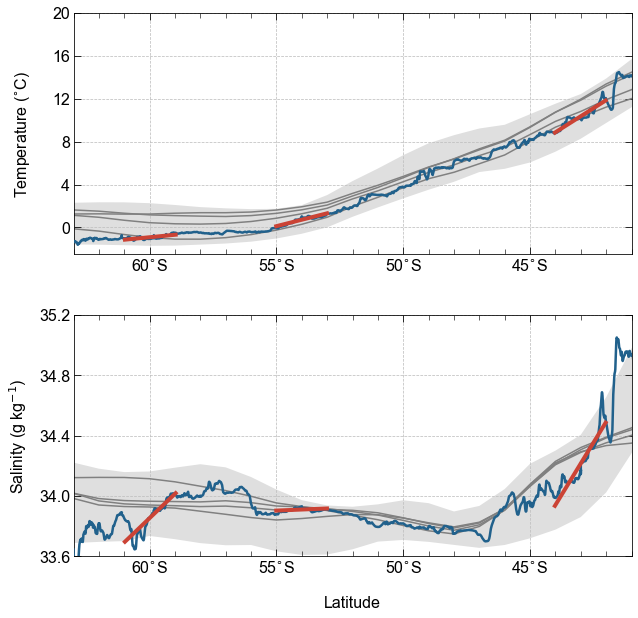

In [69]:
from sklearn.linear_model import LinearRegression
import gsw
from collections import OrderedDict

font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 16}

matplotlib.rc('font', **font)

fig, ax = subplots(2, figsize=[10, 10])

fig.subplots_adjust(hspace=0.25)
    
ax[0].fill_between(x=lat, y1=t_min, y2=t_max, facecolor='0.5', alpha=0.25)
ax[1].fill_between(x=lat, y1=s_min, y2=s_max, facecolor='0.5', alpha=0.25)
    
# plot the TSG data

tsg_props = dict(c=blue, zorder=3, alpha=1, lw=2.5)

for i, var in enumerate(['t_clean', 's_clean']):

    ax[i].plot(tsg.Latitude, 
               tsg[var], 
               **tsg_props, 
               label='Thermosalinograph'
              )

################
# EN4 ROAMMIZ
################

EN4_roammiz = EN4.sel(time=slice('2018-12-01', '2019-03-31'))

for t, val in enumerate(EN4_roammiz.time):
    
    ax[0].plot(EN4_roammiz.lat, EN4_roammiz.temperature.sel(lon=0.)[t], lw=1.5, c='0.5', zorder=2)
    ax[1].plot(EN4_roammiz.lat, EN4_roammiz.salinity.sel(lon=0.)[t]   , lw=1.5, c='0.5', zorder=2)

    

########################
# linear regression to find the slope (gradient) for each glider location
########################

for dat in [dat_saz_interp, dat_apz_interp, dat_miz_interp]:
  
    idx = ((tsg.Latitude > dat.lat.mean(dim='time').values-1) & (tsg.Latitude < dat.lat.mean(dim='time').values+1))

    X = tsg.Latitude.values[idx]
    T = tsg.t_clean.values[idx]
    S = tsg.s_clean.values[idx]
  
    i_good=~np.isnan(T) # find the good data
    X = X[i_good]; T = T[i_good]; S = S[i_good]
  
    i_good=~np.isnan(S) # find the good data
    X = X[i_good]; T = T[i_good]; S = S[i_good]
  
    X = X.reshape(-1, 1)
    T = T.reshape(-1, 1)
    S = S.reshape(-1, 1)
  
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, T)  # perform linear regression
    T_pred = linear_regressor.predict(X)  # make predictions
  
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, S)  # perform linear regression
    S_pred = linear_regressor.predict(X)  # make predictions
  
    ax[0].plot(X, T_pred, c=red, lw=4, zorder=10)
    ax[1].plot(X, S_pred, c=red, lw=4, zorder=10)
  
    dat['dT_tsg'] = (T_pred[-1] - T_pred[0]) / gsw.distance([0, 0], [X[-1].squeeze(), X[0].squeeze()]) # temperature gradients in degC / m
    dat['dS_tsg'] = (S_pred[-1] - S_pred[0]) / gsw.distance([0, 0], [X[-1].squeeze(), X[0].squeeze()]) # salinity gradients in psu / m
    
    
ax[0].set_ylabel('Temperature ($^{\circ}$C)', labelpad=20)
ax[1].set_ylabel('Salinity (g kg$^{-1}$)', labelpad=10)

# yticks
ax[0].yaxis.set_ticks(np.arange(0, 22, 4))
ax[1].yaxis.set_ticks(np.arange(33.6, 36, 0.4))


ax[0].set_ylim(-2.5, 20)
ax[1].set_ylim(33.6, 35.2)

ax[1].set_xlabel('Latitude', labelpad=20)

for a in ax:
    
    a.xaxis.set_ticks(np.arange(-63, -37, 1), minor=True)
#     a.spines['right'].set_visible(False)
#     a.spines['top'].set_visible(False)
    a.grid(lw=0.75, c='0.75', ls='--')
    a.set_xlim(-63, -41)
    a.yaxis.set_ticks_position('both')
    a.xaxis.set_ticks_position('both')
    
    a.set_xticks([-60, -55, -50, -45])
    a.xaxis.set_ticklabels(['60$^{\circ}$S', '55$^{\circ}$S', '50$^{\circ}$S', '45$^{\circ}$S'])

plt.savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/fig5_gradients.png', dpi=300, bbox_inches='tight')

Next, plot the zoom of the Sailbuoy gradients

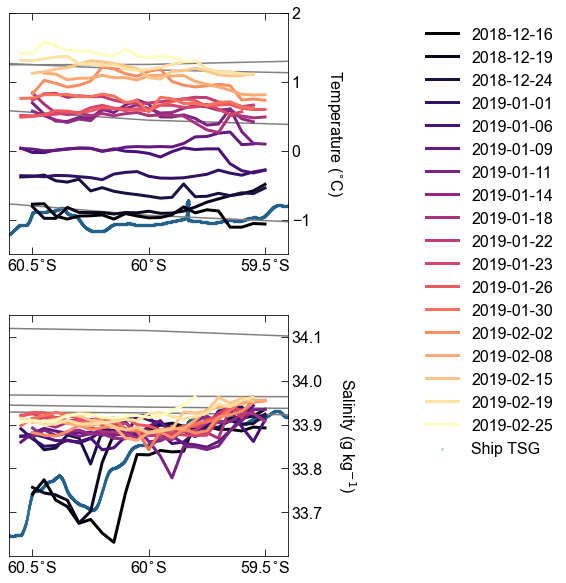

In [70]:
fig, ax = subplots(2, figsize=[5, 10])

fig.subplots_adjust(hspace=0.25)

###################
#### Sailbuoy #####
###################

evenly_spaced_interval = np.linspace(0, 1, len(date_transect))
colors = [cm.magma(x) for x in evenly_spaced_interval]

for i in range(len(date_transect)):

    Ys = sb_s_grid[:, i]
    Yt = sb_t_grid[:, i]
    
    ax[0].plot(lat_bins, Yt    , color=colors[i], zorder=i+10, lw=3, label=str(date_transect[i].values)[:10]) 
    ax[1].plot(lat_bins, Ys+0.3, color=colors[i], zorder=i+10, lw=3, label=str(date_transect[i].values)[:10]) 


###############
#### TSG #####
###############

ax[0].scatter(tsg.Latitude, tsg.t_clean, s=10, label='Ship TSG', color=blue, alpha=0.25, lw=0)
ax[1].scatter(tsg.Latitude, tsg.s_clean, s=10, label='Ship TSG', color=blue, alpha=0.25, lw=0)

ax[0].set_ylim(-1.5,2)
ax[1].set_ylim(33.6, 34.15)


################
###### EN4 #####
################

EN4_roammiz = EN4.sel(time=slice('2018-12-01', '2019-03-31'))

for t, val in enumerate(EN4_roammiz.time):
    
    ax[0].plot(EN4_roammiz.lat, EN4_roammiz.temperature.sel(lon=0.)[t], lw=1.5, c='0.5')
    ax[1].plot(EN4_roammiz.lat, EN4_roammiz.salinity.sel(lon=0.)[t]   , lw=1.5, c='0.5')
    
ax[0].yaxis.set_ticks([-1, 0, 1, 2])
ax[1].yaxis.set_ticks([33.7, 33.8, 33.9, 34.0, 34.1])

[a.yaxis.tick_right() for a in ax]

for a in ax:
    
    a.set_xlim(-60.6, -59.4)
    a.set_xticks([-60.5, -60, -59.5])
    a.xaxis.set_ticklabels(['60.5$^{\circ}$S', '60$^{\circ}$S', '59.5$^{\circ}$S'])
    a.yaxis.set_ticks_position('both')
    a.xaxis.set_ticks_position('both')
    a.yaxis.set_label_position("right")
    
ax[0].set_ylabel('Temperature ($^{\circ}$C)', labelpad=35, rotation=-90)
ax[1].set_ylabel('Salinity (g kg$^{-1}$)', labelpad=35, rotation=-90)

ax[0].legend(loc='upper right', bbox_to_anchor=(2, 1), frameon=False)
    

plt.savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/fig5_gradients_miz.png', dpi=300, bbox_inches='tight')

Determine the T and S gradients for the MIZ from the Sailbuoy data

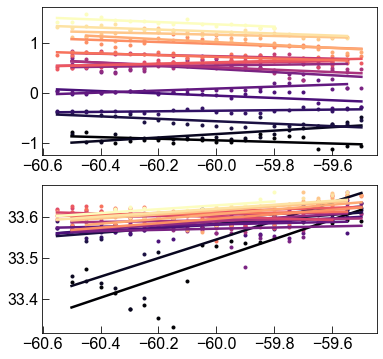

In [71]:
from sklearn.linear_model import LinearRegression
import scipy

fig,ax=subplots(2,figsize=[6, 6])

dT_grad=[]
dS_grad=[]

for i in range(len(date_transect)):

    X = lat_bins
    S = sb_s_grid[:, i]
    T = sb_t_grid[:, i]
    
    i_good=~np.isnan(T) # find the good data
    X = X[i_good]; T = T[i_good]; S = S[i_good]
    
    i_good=~np.isnan(S) # find the good data
    X = X[i_good]; T = T[i_good]; S = S[i_good]
    
    X = X.reshape(-1, 1)
    T = T.reshape(-1, 1)
    S = S.reshape(-1, 1)
    
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, T)  # perform linear regression
    T_pred = linear_regressor.predict(X)  # make predictions
    
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, S)  # perform linear regression
    S_pred = linear_regressor.predict(X)  # make predictions
    
    evenly_spaced_interval = np.linspace(0, 1, len(date_transect))
    colors = [cm.magma(x) for x in evenly_spaced_interval]
    
    ax[0].plot(X, T     , color=colors[i], zorder=0, lw=0.0, label='SB '+str(date_transect[i].values)[:10], marker='.') 
    ax[0].plot(X, T_pred, color=colors[i], zorder=10, lw=2.5, label='SB '+str(date_transect[i].values)[:10]) 
    
    ax[1].plot(X, S      , color=colors[i], zorder=0, lw=0.0, label='SB '+str(date_transect[i].values)[:10], marker='.') 
    ax[1].plot(X, S_pred , color=colors[i], zorder=10, lw=2.5, label='SB '+str(date_transect[i].values)[:10])  
    
    dT_grad += (T_pred[-1] - T_pred[0]) / gsw.distance([0, 0], [X[-1].squeeze(), X[0].squeeze()]), # temperature gradients in degC / m
    dS_grad += (S_pred[-1] - S_pred[0]) / gsw.distance([0, 0], [X[-1].squeeze(), X[0].squeeze()]), # salinity gradients in psu / m
    
dat_miz_interp['dT_grad'] = (('time'), scipy.interpolate.griddata(date2num(date_transect), np.array(dT_grad).squeeze(), date2num(dat_miz_interp.time)))
dat_miz_interp['dS_grad'] = (('time'), -scipy.interpolate.griddata(date2num(date_transect), np.array(dS_grad).squeeze(), date2num(dat_miz_interp.time)))

Determine the T and S gradients for the SAZ and APZ from the EN4 data

In [72]:
EN4_saz = EN4_roammiz.sel(lon=8., lat=slice(-44, -42))
EN4_apz = EN4_roammiz.sel(lon=0., lat=slice(-55, -53))


dT_grad_saz=[];dS_grad_saz=[];
dT_grad_apz=[];dS_grad_apz=[];

for i in range(4):
    
    dT_grad_saz += (EN4_saz.temperature[i][0]-EN4_saz.temperature[i][-1]).values / gsw.distance([8, 8], [-44, -42]),
    dS_grad_saz += (EN4_saz.salinity   [i][0]-EN4_saz.salinity   [i][-1]).values / gsw.distance([8, 8], [-44, -42]),
    
    dT_grad_apz += (EN4_apz.temperature[i][0]-EN4_apz.temperature[i][-1]).values / gsw.distance([0, 0], [-55, -53]),
    dS_grad_apz += (EN4_apz.salinity   [i][0]-EN4_apz.salinity   [i][-1]).values / gsw.distance([0, 0], [-55, -53]),
    
dS_grad_saz = np.array(dS_grad_saz).squeeze()
dT_grad_saz = np.array(dT_grad_saz).squeeze()
dS_grad_apz = np.array(dS_grad_apz).squeeze()
dT_grad_apz = np.array(dT_grad_apz).squeeze()

In [73]:
dat_saz_interp['dT_grad'] = (('time'), scipy.interpolate.griddata(date2num(EN4_saz.time.values), np.array(dT_grad_saz).squeeze(), date2num(dat_saz_interp.time)))
dat_saz_interp['dS_grad'] = (('time'), scipy.interpolate.griddata(date2num(EN4_saz.time.values), np.array(dS_grad_saz).squeeze(), date2num(dat_saz_interp.time)))

dat_apz_interp['dT_grad'] = (('time'), scipy.interpolate.griddata(date2num(EN4_apz.time.values), np.array(dT_grad_apz).squeeze(), date2num(dat_apz_interp.time)))
dat_apz_interp['dS_grad'] = (('time'), scipy.interpolate.griddata(date2num(EN4_apz.time.values), np.array(dS_grad_apz).squeeze(), date2num(dat_apz_interp.time)))

Fill the nan values

In [74]:
for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):
    
    dat['dT_grad'] = dat['dT_grad'].ffill(dim='time').bfill(dim='time')
    dat['dS_grad'] = dat['dS_grad'].ffill(dim='time').bfill(dim='time')

### Determine the Ekman and mixing layer depths

Frictional velocity

$ u_* = \sqrt{\tau/\rho} $

From Pollard Rhines and Thompson 1972

$ h_{prt} \sim u_* / \sqrt{N/f} $

Ekman depth

$ h_{ek} = \kappa (u_* / |f|) $

In [75]:
for dat in [dat_saz_interp, dat_apz_interp, dat_miz_interp]:
    
    dat['buoyancy'] = -9.81*(dat['density']-1025)/1025
    dat['N2'] = -dat['buoyancy'].diff(dim='depth')

In [76]:
for dat in [dat_saz_interp, dat_apz_interp, dat_miz_interp]:
    
    # first lets determine N within the mixed layer
    
    n = []
    
    for i, m in enumerate(np.round(dat['mld_03'].astype(int))):
        
        n += np.sqrt(dat.N2.sel(depth=slice(10, m-5)).mean(dim='depth').values[i]),
        
    n = np.median(np.array(n))

    dat['u_star'] = (('time'), sqrt(dat['tau']/1027))                            # frictional velocity
    n             = np.sqrt(dat['N2'][:,10:100].median(dim='depth')).ffill(dim='time')   # stratification
    f             = gsw.f(dat['lat'].mean(dim='time'))                                # coriolis frequency
    k             = 0.41                                                             # von kamrmans constant
        
    dat['h_prt']  = (('time'), np.power(2,0.75)*dat['u_star']/(sqrt(np.abs(n*f))))
    dat['h_ek']   = (('time'), k*(np.abs(dat['u_star']/f)))

### Determining mixing layer depth

In [77]:
dat = dat_apz_interp

xld_apz = pd.read_csv('../../data/mixing_layer_xld.csv')
xld_apz = xr.DataArray(xld_apz.xld, coords=[xld_apz.Date.astype(datetime64)], dims=["time"])

xld_apz = xld_apz.interp_like(dat.mld_03)

dat_apz_interp['xld'] = (('time'), xld_apz)

dat['u_star'] = (('time'), sqrt(dat['tau']/1027)) 


First, we plot the Ekman layer depth and the PRT depth against the actual mixing depth

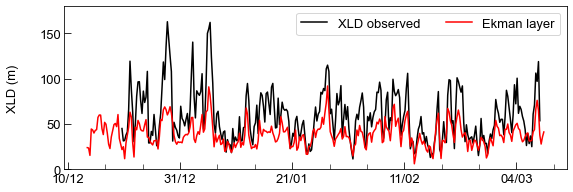

In [78]:
# change the font size
font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 13}

matplotlib.rc('font', **font)

fig,ax = subplots(figsize=(9,3))

ax.plot(dat_apz_interp.time, dat_apz_interp.xld,   c='k', label='XLD observed')
ax.plot(dat_apz_interp.time, dat_apz_interp.h_ek,  c='r', label='Ekman layer')

ax.set_ylim(0, 180)

ax.xaxis.set_major_locator(weeks)
ax.xaxis.set_minor_locator(week)
ax.xaxis.set_major_formatter(yearsFmt)

ax.set_ylabel('XLD (m)', labelpad=20)
ax.legend(ncol=2, loc=1)

savefig('../../figures/XLD_observed_ekman_layer.png', dpi=300, bbox_inches='tight')

What is the RMSE between the XLD and the ekman layer?

In [79]:
np.corrcoef(dat_apz_interp.xld[dat_apz_interp.xld>0], dat_apz_interp.h_ek[dat_apz_interp.xld>0])

array([[1.        , 0.83317973],
       [0.83317973, 1.        ]])

In [80]:
np.sqrt((dat_apz_interp.xld - dat_apz_interp.h_ek)**2).mean()

<xarray.DataArray ()>
array(20.92658086)

Calculate the mixing layer regression

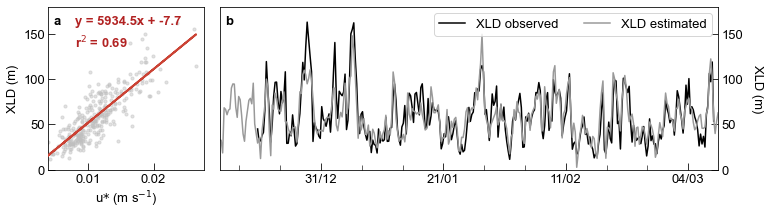

In [81]:
### MIXING LAYER DEPTH REGRESSION

# setting the plot
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12,3))
gs = gridspec.GridSpec(nrows=1,ncols=4, wspace=0.1)  # sets a grid of 1 rows by 4 column

# mixing layer u-star regression

ax = fig.add_subplot(gs[0, 0]) # this says first 3 grid points in rows, and 2 columns i.e., (a)

ax.scatter(dat.u_star, dat.xld, c='0.75', alpha=0.45, s=10)

ax.set_xlim(0.004)
ax.set_ylim(0, 180)

X = dat['u_star'].values
Y = dat['xld'].values

i_good=~np.isnan(Y) # find the good data
X = X[i_good]; Y = Y[i_good]

X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

ax.plot(X, Y_pred, c=red, lw=2, zorder=10)

# get the slope and intercept
slope     = np.round(linear_regressor.coef_.squeeze(), 1)
intercept = np.round(linear_regressor.intercept_.squeeze(), 1)

ax.text(0.008, 160, 'y = '+str(slope)+'x + ' + str(intercept), fontweight='bold', c='firebrick')

# correlation
corr = np.round(linear_regressor.score(X, Y), 2)  # perform linear regression
ax.text(0.008, 135, 'r$^2$ = ' + str(corr), fontweight='bold', c='firebrick')

ax.set_xlabel('u$*$ (m s$^{-1}$)')
ax.set_ylabel('XLD (m)')

ax.text(0.0047, 160, 'a', fontweight='bold')

# mixing layer observed vs estimated
ax = fig.add_subplot(gs[0, 1:4]) # this says first 3 grid points in rows, and 2 columns i.e., (a)

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

ax.plot(dat_apz_interp.time, dat_apz_interp.xld, c='k', label='XLD observed')
ax.plot(dat_apz_interp.time, slope*dat_apz_interp['u_star']+intercept, c='0.6', label='XLD estimated')

ax.set_ylim(0, 180)

ax.xaxis.set_major_locator(weeks)
ax.xaxis.set_minor_locator(week)
ax.xaxis.set_major_formatter(yearsFmt)

ax.set_ylabel('XLD (m)', rotation=-90, labelpad=20)
ax.legend(ncol=2, loc=1)

ax.text(dat_apz_interp.time.values[4], 160, 'b', fontweight='bold')

ax.set_xlim(dat_apz_interp.time.values[0], dat_apz_interp.time.values[-1])

savefig('../../figures/XLD_observed_estimated.png', dpi=300, bbox_inches='tight')

#### Determine the estimated mixing depth for all sites

In [82]:
for dat in [dat_saz_interp, dat_apz_interp, dat_miz_interp]:
    
    dat['u_star'] = (('time'), sqrt(dat['tau']/1027)) # frictional velocity
    dat['xld_est'] = slope*dat['u_star']+intercept    # estimated mixing depth

Plot H_prt and H_ek for all the sites compared to the mixed layer 

In [97]:
dat_saz_1D = dat_saz_interp.resample(time='1D', loffset='12H').mean()
dat_apz_1D = dat_apz_interp.resample(time='1D', loffset='12H').mean()
dat_miz_1D = dat_miz_interp.resample(time='1D', loffset='12H').mean()

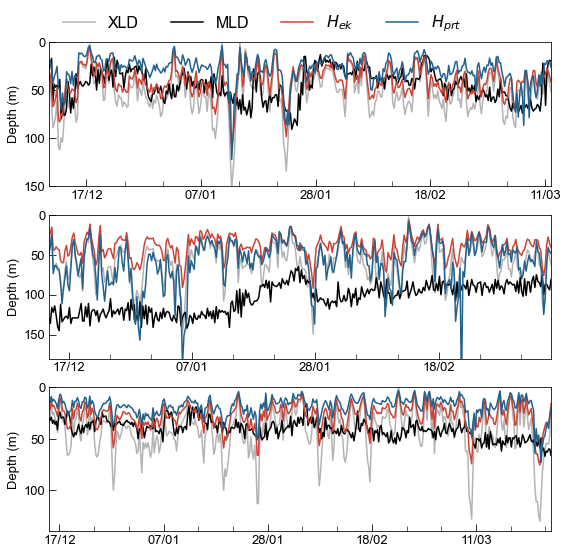

In [107]:
fig,ax=subplots(3, figsize=[9,9]) 

for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):

    ax[i].plot(dat.time, dat.xld_est, c='0.7', label='XLD')
    ax[i].plot(dat.time, dat.mld_03,  c='k',   label='MLD')
    ax[i].plot(dat.time, dat.h_ek,    c=red,   label='$H_{ek}$')
    ax[i].plot(dat.time, dat.h_prt,   c=blue,  label='$H_{prt}$')
    
    ax[i].set_ylabel('Depth (m)')
    
    ax[i].set_xlim(dat.time.values[0], dat.time.values[-1])
    
    ax[i].xaxis.set_major_locator(weeks)
    ax[i].xaxis.set_minor_locator(week)
    ax[i].xaxis.set_major_formatter(yearsFmt)
    
ax[0].set_ylim(150, 0)
ax[1].set_ylim(180, 0)
ax[2].set_ylim(140, 0)

ax[0].legend(loc=2, bbox_to_anchor=(0, 1.3), fontsize=16, frameon=False, ncol=4)

savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/Final Figures/Fig_S1_xld_hek_hprt_mld.png', dpi=300)

### Rossby radius of deformation length scale

In [109]:
for dat in [dat_saz_interp, dat_apz_interp, dat_miz_interp]:
    
    n = []
    
    for i, m in enumerate(np.round(dat['mld_03'].astype(int))):
        
        n += np.sqrt(dat.N2.sel(depth=slice(5, m+10)).mean(dim='depth').values[i]),
        
    Lf = np.nanmean((n * dat.mld_03) / gsw.f(dat.lat))
    
#     print(np.nanmean(n))
    
    print(Lf)

-2104.181119545785
-2061.040811518426
-1930.7371083637845


### Figure 6
---

Glider sections of stratification

In [110]:
for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):
    dat['pot_den'] = gsw.pot_rho_t_exact(dat.salt, dat.temp, dat.depth/1000, 10.1325)

<ipython-input-111-92539e7f3553>:37: UserWarning: No contour levels were found within the data range.
  ax[i].contour(dat.time.values, dat.depth, dat.pot_den.T, levels=[1027.3], colors=red, linewidths=2)


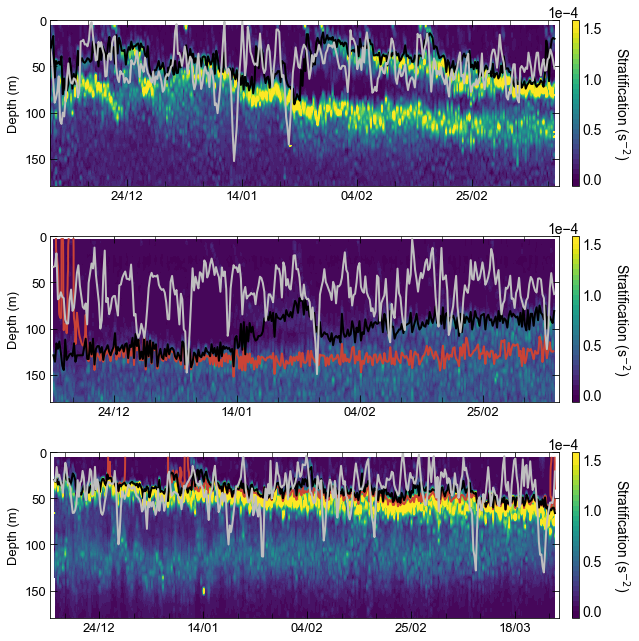

In [111]:
fig, ax = subplots(3, 1, figsize=[11,11])
fig.subplots_adjust(hspace=0.3)

# change the font size
font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 14}

matplotlib.rc('font', **font)

for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):
    
    im=ax[i].contourf(dat.time.values, dat.depth, dat.N2.T, levels=np.arange(0, 1.55e-4, 0.5e-5), extend='both')
    cb=colorbar(mappable=im, ax=ax[i], pad=0.02, extendrect=True, drawedges=False, ticks=np.arange(0, 4e-4, 0.5e-4))
    cb.ax.tick_params(width=0)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    
    ax[i].xaxis.set_major_locator(weeks)
    ax[i].xaxis.set_minor_locator(week)
    ax[i].xaxis.set_major_formatter(yearsFmt)
    
    ax[i].plot(dat.time, rolling_mean(dat.mld_03,   window=1), c='k',   lw=2)
    ax[i].plot(dat.time, rolling_mean(dat.xld_est , window=1), c='0.75',lw=2)
    
#     ax[i].contour(dat.time.values, dat.depth, dat.density.T, levels=np.arange(1026, 1029, 0.1), colors='0.75', linewidths=1, alpha=0.75)
    
    ax[i].set_ylim(180, 0)
    ax[i].set_ylabel('Depth (m)', labelpad=5)
    ax[i].set_xlabel('', labelpad=5)
    
    cb.set_label('Stratification (s$^{-2}$)', rotation=-90, labelpad=30)
    
    ax[i].yaxis.set_ticks_position('both')
    ax[i].xaxis.set_ticks_position('both')
    
    ax[i].contour(dat.time.values, dat.depth, dat.pot_den.T, levels=[1027.3], colors=red, linewidths=2)
    
ax[0].set_xlim(pd.to_datetime('2018-12-10'), pd.to_datetime('2019-03-13'))
ax[1].set_xlim(pd.to_datetime('2018-12-13'), pd.to_datetime('2019-03-10'))
ax[2].set_xlim(pd.to_datetime('2018-12-14'), pd.to_datetime('2019-03-27'))

# ax[0].text(pd.to_datetime('2018-12-11'), -5, 'a', fontweight='bold')
# ax[1].text(pd.to_datetime('2018-12-14'), -5, 'b', fontweight='bold')
# ax[2].text(pd.to_datetime('2018-12-15'), -5, 'c', fontweight='bold')

# ax[0].text(dat_saz_interp.time.values[20], 150, 'XLD', color=red, fontsize=16, fontweight='bold')
# ax[0].text(dat_saz_interp.time.values[55], 150, 'MLD', color='k', fontsize=16, fontweight='bold')
    
savefig('../../figures/fig6_N2_glider_sections.png', dpi=300, bbox_inches='tight')

## Tendency figure
---

#### Load the air-sea heat and freshwater fluxes

Mixed layer budget analysis

#### Load the ADT values

In [112]:
# adt = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/adt/*.nc')
# adt = my.adjust_lon_xr_dataset(adt, lon_name='longitude')
# adt = adt.resample(time='6H', loffset='3H').mean()

# var_name = ['ugos', 'vgos']   

# for var in tqdm(var_name):

#     dat_saz_interp[var] = (('time'), my.interp_glider_era5(dat_saz_interp, adt.sel(longitude=slice(5, 10), latitude=slice(-45, -40)), var=var))
#     dat_apz_interp[var] = (('time'), my.interp_glider_era5(dat_apz_interp, adt.sel(longitude=slice(-5, 5), latitude=slice(-56, -52)), var=var))
#     dat_miz_interp[var] = (('time'), my.interp_glider_era5(dat_miz_interp, adt.sel(longitude=slice(-5, 5), latitude=slice(-63, -56)),var=var))

#### Load the difference flux products

ERA5

In [113]:
# import my_functions as my

# era5 = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/ERA5_flux_data/*.nc')
# era5 = era5.sel(latitude=slice(-40, -65), longitude=slice(-30, 30))

# # convert from J m-2 to W m-2
# var_name=['slhf', 'sshf', 'str', 'ssr', 'tp', 'e']
# era5=my.convert_era5_to_Wm2(ds=era5, var_name=var_name)

# # calculate net fluxes and emp
# era5['emp']  = (('time', 'latitude', 'longitude'), era5['e']-era5['tp'])
# era5['qnet'] = (('time', 'latitude', 'longitude'), era5['slhf']+era5['sshf']+era5['str']+era5['ssr'])

# # interp to the resolution of the glider
# era5_interp = era5.resample(time=interp_res, loffset=offset).mean()

2.2 JRA-55

In [114]:
# ep_jra55 = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/precipitation_evaporation/JRA55/*.nc')
# hf_jra55 = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/heat_flux/JRA55/*.nc')
# ws_jra55 = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/wind_speed/JRA55/*.nc')

# # merge the datasets
# jra55 = xr.merge([ep_jra55, hf_jra55, ws_jra55])

# # correct the longitudes
# jra55 = my.adjust_lon_xr_dataset(jra55, lon_name='g4_lon_2')

# # Change to consisent naming convention for longitude and latitudes
# jra55 = jra55.rename({'g4_lat_1'           : 'latitude',
#                       'g4_lon_2'           : 'longitude',
#                       'initial_time0_hours': 'time'})

# # rename variables
# jra55 = jra55.rename({
#                       'LHTFL_GDS4_SFC_ave3h': 'slhf',
#                       'SHTFL_GDS4_SFC_ave3h': 'sshf',
#                       'DSWRF_GDS4_SFC_ave3h': 'dssr',
#                       'USWRF_GDS4_SFC_ave3h': 'ussr',
#                       'DLWRF_GDS4_SFC_ave3h': 'dstr',
#                       'ULWRF_GDS4_SFC_ave3h': 'ustr',
#                       'EVP_GDS4_SFC_ave3h'  : 'e',
#                       'TPRAT_GDS4_SFC_ave3h': 'tp',
#                       'UGRD_GDS4_HTGL'      : 'u10',
#                       'VGRD_GDS4_HTGL'      : 'v10',})

# jra55 = jra55.sel(latitude=slice(-40, -65), longitude=slice(-30, 30))

# jra55['e']  = (('time', 'latitude', 'longitude'), -jra55['e']/(86400*1000))
# jra55['tp'] = (('time', 'latitude', 'longitude'),  jra55['tp']/(86400*1000))

# jra55['ssr'] = (('time', 'latitude', 'longitude'),  jra55['dssr']-jra55['ussr'])
# jra55['str'] = (('time', 'latitude', 'longitude'),  jra55['dstr']-jra55['ustr'])

# jra55['sshf'] = (('time', 'latitude', 'longitude'),  -jra55['sshf'])
# jra55['slhf'] = (('time', 'latitude', 'longitude'),  -jra55['slhf'])

# # calculate net fluxes and emp
# jra55['emp']  = (('time', 'latitude', 'longitude'), jra55['e']   -jra55['tp'])
# jra55['qnet'] = (('time', 'latitude', 'longitude'), jra55['slhf']+jra55['sshf']+jra55['str']+jra55['ssr'])

# # interp to the resolution of the glider
# jra55_interp = jra55.resample(time=interp_res, loffset=offset).mean()

2.3 MERRA-2

In [115]:
# ep_merra = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/precipitation_evaporation/MERRA2/*.nc4')
# hf_merra = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/heat_flux/MERRA2/*.nc4')
# ws_merra = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/wind_speed/MERRA2/*.nc4')

# # merge the datasets
# merra = xr.merge([ep_merra, hf_merra, ws_merra])
# merra = merra.sel(lat=slice(-65, -40), lon=slice(-30, 30))

# # correct the longitudes
# merra = my.adjust_lon_xr_dataset(merra, lon_name='lon')

# # Change to consisent naming convention for longitude and latitudes
# merra = merra.rename({'lat': 'latitude',
#                     'lon': 'longitude'})

# # rename variables
# merra = merra.rename({
#                     'EFLUX'  : 'slhf',
#                     'HFLUX'  : 'sshf',
#                     'SWGNT'  : 'ssr',
#                     'LWGNT'  : 'str',
#                     'EVAP'   : 'e',
#                     'PRECTOT': 'tp',
#                     'U10M'   : 'u10',
#                     'V10M'   : 'v10'})

# merra['e']  = (('time', 'latitude', 'longitude'), -merra['e']/(1025))
# merra['tp']  = (('time', 'latitude', 'longitude'), merra['tp']/(1025))

# merra['sshf'] = (('time', 'latitude', 'longitude'),  -merra['sshf'])
# merra['slhf'] = (('time', 'latitude', 'longitude'),  -merra['slhf'])

# # calculate net fluxes and emp
# merra['emp']  = (('time', 'latitude', 'longitude'), merra['e']   -merra['tp'])
# merra['qnet'] = (('time', 'latitude', 'longitude'), merra['slhf']+merra['sshf']+merra['str']+merra['ssr'])

# # interp to the resolution of the glider
# merra_interp = merra.resample(time=interp_res, loffset=offset).mean()

#### Interpolate the datasets to the glider time series

In [116]:
# # interpolate to the nearest location of the glider
# from tqdm import tqdm

# # var_name = ['slhf','sshf','str' ,'ssr' ,'tp' ,'e' ,'emp' , 'u10', 'v10', 'qnet']
# var_name = ['e', 'tp' , 'u10', 'v10', 'qnet']

# for var in tqdm(var_name):
  
#     dat_saz_interp[var+'_era5'] = (('time'), my.interp_glider_era5(dat_saz_interp, era5_interp, var=var))
#     dat_apz_interp[var+'_era5'] = (('time'), my.interp_glider_era5(dat_apz_interp, era5_interp, var=var))
#     dat_miz_interp[var+'_era5'] = (('time'), my.interp_glider_era5(dat_miz_interp, era5_interp, var=var))
    
# #     dat_saz_interp[var+'_merra'] = (('time'), my.interp_glider_era5(dat_saz_interp, merra_interp, var=var))
# #     dat_apz_interp[var+'_merra'] = (('time'), my.interp_glider_era5(dat_apz_interp, merra_interp, var=var))
# #     dat_miz_interp[var+'_merra'] = (('time'), my.interp_glider_era5(dat_miz_interp, merra_interp, var=var))
    
# #     dat_saz_interp[var+'_jra55'] = (('time'), my.interp_glider_era5(dat_saz_interp, jra55_interp, var=var))
# #     dat_apz_interp[var+'_jra55'] = (('time'), my.interp_glider_era5(dat_apz_interp, jra55_interp, var=var))
# #     dat_miz_interp[var+'_jra55'] = (('time'), my.interp_glider_era5(dat_miz_interp, jra55_interp, var=var))

#### Calculate the wind stress

In [117]:
# import airsea

# # reanalysis = ['era5', 'merra', 'jra55']
# reanalysis = ['era5']

# for r in reanalysis:

#     for dat in [dat_saz_interp, dat_apz_interp, dat_miz_interp]:
        
#         dat['taux_'+str(r)] = (('time'), airsea.windstress.stress(dat['u10_'+str(r)], z=10., drag='largepond'))
#         dat['tauy_'+str(r)] = (('time'), airsea.windstress.stress(dat['v10_'+str(r)], z=10., drag='largepond'))
        
#         dat['tau_'+str(r)] = (('time'), np.sqrt(dat['taux_'+str(r)]**2 + dat['tauy_'+str(r)]**2))

In [118]:
# dat_saz_interp.to_netcdf('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/dat_saz_L3.nc')
# dat_apz_interp.to_netcdf('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/dat_apz_L3.nc')
# dat_miz_interp.to_netcdf('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/dat_miz_L3.nc')

# 1. Air-sea heat and freshwater fluxes

In this section, we plot the impacts of heat and freshwater fluxes. The first step is to calculate the heat and freshwater fluxes using the budget equation. We assume that the heat and freshwater is being distributed within the wind-driven turbulent layer of the ocean, which we call $h_{max}$. 

But first, let's assign the heat and freshwater budget equations:

In [119]:
def heatflux(Q, mld, rho=1027, Cp=3850):
    
    return (Q / (rho * Cp * mld)) # units of C/s

def freshwaterflux(E, P, mld, S):
    
    return (( (E-P) * S ) / mld) # units psu/s

Now let's do the calculation

In [120]:
for dat in [dat_saz_interp, dat_apz_interp, dat_miz_interp]:
    
    dat['ml_s_smooth'] = dat['ml_s_smooth'].bfill(dim='time').ffill(dim='time')
    dat['ml_t_smooth'] = dat['ml_t_smooth'].bfill(dim='time').ffill(dim='time')
    
    Q   = dat['qnet']
    mld = dat['mld_03']      
    E   = dat['e']   
    P   = dat['tp']  
    S   = dat['ml_s_smooth']        
  
    dat['dT_hf']    = heatflux(Q=Q, mld=mld)      
    dat['dS_ff']    = freshwaterflux(E=E, P=P, mld=mld, S=S)

# 2. Ekman Advection calculation

Next, we look at Ekman advection as a possible mechanism which moves gradients around

In [121]:
import scipy

def ekman_transport(dat, dt, grad, rho0=1027):

    f    = np.abs(gsw.f(dat['lat'])) # coriolis s-1
    taux = dat['taux']               # wind stress
    h    = dat['xld_est']            # mixing layer depth
    u10  = dat['u10']                # u-component of the wind
    
    taux[u10<0] = -taux[u10<0]       # make the u-wind stress negative when the wind is blowing westward
    
    dat['ek_vel_v'] = taux / (rho0 * h * f) # caluclate ekman velocity in units of m s-1
    
    dat['ek_trans_dS'] =  (( dat['ek_vel_v'] * dat['dS_'+grad].values)) # mutiply the ekman anomaly (m) to the gradients (g kg-1 m-1) to get g kg-1
    dat['ek_trans_dT'] =  (( dat['ek_vel_v'] * dat['dT_'+grad].values)) # degC
    

    
    return dat

Now do the calculations

In [122]:
from scipy import integrate

for dat in [dat_saz_interp, dat_apz_interp]:
        
    dat = ekman_transport(dat, dt=86400, grad='tsg')
    
dat_miz_interp = ekman_transport(dat_miz_interp, dt=86400, grad='grad')

# 3. Entrainment

In [123]:
def entrainment(dat, mld, xld, dt):
    
    mld = gt.cleaning.rolling_window(mld, func=np.mean, window=4) # smoothing window over mld
    xld = gt.cleaning.rolling_window(xld, func=np.mean, window=4) # smoothing window over xld
    
    d_mld = xld-mld # difference between xld and mld
    dh    = np.append(np.array(0), np.diff(mld)).astype(int) # rate of xld deepening in units m, positive = deepening
    
    we = dh/dt    # entrainment velocity is the rate of xld deepening in m/s
    we[we<0]=0    # if the entrainment vel is negative, there is no entrainment
    we[d_mld<0]=0 # if the entrainment vel is negative, there is no entrainment
    
    xld = xld.astype(int).values # make the xld and mld integers
    mld = mld.astype(int).values # make the xld and mld integers

    T_xld = [np.mean([dat.temp.values[i, val], dat.temp.values[i, mld[i]]]) for i, val in enumerate(xld)] # get the mean temperature between the xld and mld
    S_xld = [np.mean([dat.salt.values[i, val], dat.salt.values[i, mld[i]]]) for i, val in enumerate(xld)] # get the mean salinity between the xld and mld

    S_mld = [dat.salt.values[i, val] for i, val in enumerate(mld)] # get the salinity at the mld
    T_mld = [dat.temp.values[i, val] for i, val in enumerate(mld)] # get the temperature at the mld
    
    S_mld_15m = [dat.salt.values[i, val+15] for i, val in enumerate(mld)] # get the salinity 5m below the mld
    T_mld_15m = [dat.temp.values[i, val+15] for i, val in enumerate(mld)] # get the temperature 5m below the mld
    
    S_xld=np.array(S_xld)
    S_mld=np.array(S_mld)
    
    T_xld=np.array(T_xld)
    T_mld=np.array(T_mld)
    
    ent_S = (we*(S_mld_15m - S_mld))/xld 
    ent_T = (we*(T_mld_15m - T_mld))/xld
    
    dat['ent_dS'] = (('time'), ent_S)
    dat['ent_dT'] = (('time'), ent_T)
    
    return dat

In [124]:
for dat in [dat_saz_interp, dat_apz_interp, dat_miz_interp]:
        
    dat = entrainment(dat=dat, mld=dat['mld_03'], xld=dat['xld_est'], dt=21600)

## 4. Geostrophic Eddy Advection

In [125]:
# def eddy_advection(dat, grad='tsg'):
  
#     dat['geo_dS_v'] = (('time'), (dat['vgos'] * dat['dS_'+grad].values))
#     dat['geo_dT_v'] = (('time'), (dat['vgos'] * dat['dT_'+grad].values))
    
#     dat['geo_dS_u'] = (('time'), (dat['ugos'] * dat['dS_'+grad].values))
#     dat['geo_dT_u'] = (('time'), (dat['ugos'] * dat['dT_'+grad].values))
    
#     dat['geo_dS'] = (('time'), dat['geo_dS_v'].values)
#     dat['geo_dT'] = (('time'), dat['geo_dT_v'].values)
  
#     return dat

In [126]:
# for dat in [dat_saz_interp, dat_apz_interp, dat_miz_interp]:
#     dat['vgos'] = dat['vgos'].bfill(dim='time').ffill(dim='time')
#     dat['ugos'] = dat['ugos'].bfill(dim='time').ffill(dim='time')

In [127]:
# for dat in [dat_saz_interp, dat_apz_interp]:
      
#     dat = eddy_advection(dat, grad='tsg')

# dat_miz_interp = eddy_advection(dat_miz_interp, grad='grad')

## Plot mixed layer tendency

In [128]:
dat_saz_1D = dat_saz_interp.resample(time='1D', loffset='12H').mean()
dat_apz_1D = dat_apz_interp.resample(time='1D', loffset='12H').mean()
dat_miz_1D = dat_miz_interp.resample(time='1D', loffset='12H').mean()

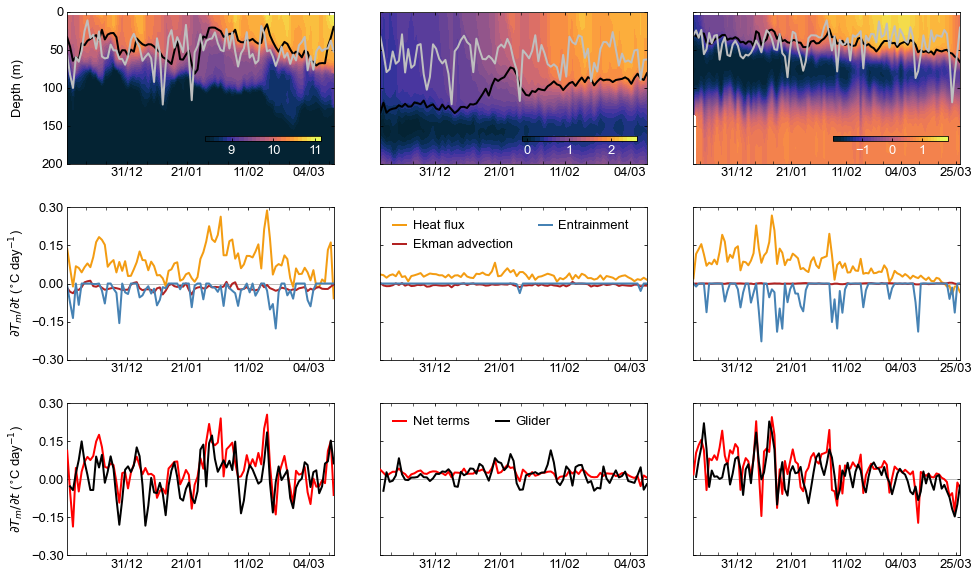

In [129]:
# change the font size
font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 13}

matplotlib.rc('font', **font)

rc('ytick.major', size=3)
rc('xtick.major', size=3)
rc('ytick.minor', size=3)
rc('xtick.minor', size=3)

# set the plot
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16,10))

gs = gridspec.GridSpec(nrows=9,ncols=3)  # sets a grid of 6 rows by 4 column

fig.subplots_adjust(hspace=2, wspace=0.175)

props=dict(fontsize=12)

for i, dat in enumerate([dat_saz_1D, dat_apz_1D, dat_miz_1D]):

    # plotting the mixed layer sections
    
    ax1 = fig.add_subplot(gs[0:3, i]) # this says first 3 grid points in rows, and 2 columns i.e., (a)
    
    vmins = [8.5,0, -1.8]
    vmaxs = [11, 2.5, 1.7]
    
    h1=ax1.contourf(dat.time.values, dat.depth, dat.temp.T, levels=np.arange(vmins[i], vmaxs[i]+0.1, 0.1), cmap=cmo.thermal, extend='both')
    
    ax1.plot(dat.time, dat.mld_03 , c='k',    lw=2)
    ax1.plot(dat.time, dat.xld_est, c='0.75', lw=2)
    
    ax1.xaxis.set_ticklabels([])
        
    ################################
    # plotting the tendency sections
    ################################
    
    ax2 = fig.add_subplot(gs[3:6, i]) # this says first 3 grid points in rows, and 2 columns i.e., (a)
    
    dat['hf_dT'] = dat['dT_hf']      *86400
    dat['ek_dT'] = dat['ek_trans_dT']*86400
    dat['en_dT'] = dat['ent_dT']     *86400
    
    
    ax2.plot(dat.time, dat['hf_dT'], c=orange,        lw=2, label='Heat flux')
    ax2.plot(dat.time, dat['ek_dT'], c='firebrick',   lw=2, label='Ekman advection')
    ax2.plot(dat.time, dat['en_dT'], c='steelblue',   lw=2, label='Entrainment')
#     ax2.plot(dat.time, dat['ga_dT'], c='steelblue',  lw=1.25, label='Geo advection')
        
    ################################
    # plotting the tendency sections
    ################################
    
    ax3 = fig.add_subplot(gs[6:9, i]) # this says first 3 grid points in rows, and 2 columns i.e., (a)        

    dat['net_terms_dT'] = dat['hf_dT'] + dat['ek_dT'] + dat['en_dT'] 
    dat['glider_dT']    = dat['ml_t_smooth'].diff(dim='time')
    
    ax3.plot(dat.time    , dat['net_terms_dT']    , label='Net terms', c='r', lw=2, zorder=10) 
    ax3.plot(dat.time[1:], dat['glider_dT'][1:],    label='Glider',    c='k', lw=2, zorder=10)     
        
    ################################
    # plotting edits
    ################################
    
    if i==0:
        ax1.set_ylabel('Depth (m)', labelpad=18)
        ax2.set_ylabel( r'$\partial T_m / \partial t$ ($^{\circ}$C day$^{-1}$)')
        ax3.set_ylabel( r'$\partial T_m / \partial t$ ($^{\circ}$C day$^{-1}$)')
        
    if i>0:
        for a in [ax1, ax2, ax3]:
            a.yaxis.set_ticklabels([])

    for a in [ax1, ax2, ax3]:
        
        a.xaxis.set_major_locator(weeks)
        a.xaxis.set_minor_locator(week)
        a.xaxis.set_major_formatter(yearsFmt)
        
        a.yaxis.set_ticks_position('both')
        a.xaxis.set_ticks_position('both')
        
#         a.grid(lw=0.5, alpha=0.5, ls='--')
        
    ax1.set_xlim(dat.time.values[0], dat.time.values[-1])
    ax2.set_xlim(dat.time.values[0], dat.time.values[-1])
    ax3.set_xlim(dat.time.values[0], dat.time.values[-1])
        
    ax1.yaxis.set_ticks([0, 50, 100, 150, 200])
    
    # legend 
    
    if i==1:
        ax1.set_ylim(200, 0)
        ax2.legend(ncol=2, loc=2, handlelength=1, handletextpad=0.5, borderpad=0.5, fontsize=13, frameon=False)
        ax3.legend(ncol=2, loc=2, handlelength=1, handletextpad=0.5, borderpad=0.5, fontsize=13, frameon=False)
    else:
        ax1.set_ylim(200, 0)
    
    # colorbars 
    
    if i==0:
        cax = fig.add_axes(([0.245, 0.7, 0.1, 0.0075]))
        cb = colorbar(mappable=h1, cax=cax, pad=0.02, extendrect=True, drawedges=False, ticks=np.arange(-2, 12.5, 1.0), orientation='horizontal')
        cb = plt.getp(cb.ax.axes, 'xticklabels') 
        plt.setp(cb, color='w')
        
    if i==1:
        cax = fig.add_axes(([0.52, 0.7, 0.1, 0.0075]))
        cb = colorbar(mappable=h1, cax=cax, pad=0.02, extendrect=True, drawedges=False, ticks=np.arange(-2, 12.5, 1.0), orientation='horizontal')
        cb = plt.getp(cb.ax.axes, 'xticklabels') 
        plt.setp(cb, color='w')
        
    if i==2:
        cax = fig.add_axes(([0.79, 0.7, 0.1, 0.0075]))
        cb = colorbar(mappable=h1, cax=cax, pad=0.02, extendrect=True, drawedges=False, ticks=np.arange(-2, 12.5, 1.0), orientation='horizontal')
        cb = plt.getp(cb.ax.axes, 'xticklabels') 
        plt.setp(cb, color='w')
        
    ax2.set_ylim(-0.3, 0.3)
    ax3.set_ylim(-0.3, 0.3)
    
    ax2.yaxis.set_ticks(np.arange(-0.3, 0.45, 0.15))
    ax3.yaxis.set_ticks(np.arange(-0.3, 0.45, 0.15))
    
    ax2.plot([pd.to_datetime('2018-12-10'), pd.to_datetime('2019-03-26')], [0, 0], zorder=0, lw=1, c='0.75')
    ax3.plot([pd.to_datetime('2018-12-10'), pd.to_datetime('2019-03-26')], [0, 0], zorder=0, lw=1, c='0.75')
    

savefig('../../figures/temp_tendency_breakdown.png', dpi=300, bbox_inches='tight')

## Plot mixed layer tendency - Salinity 

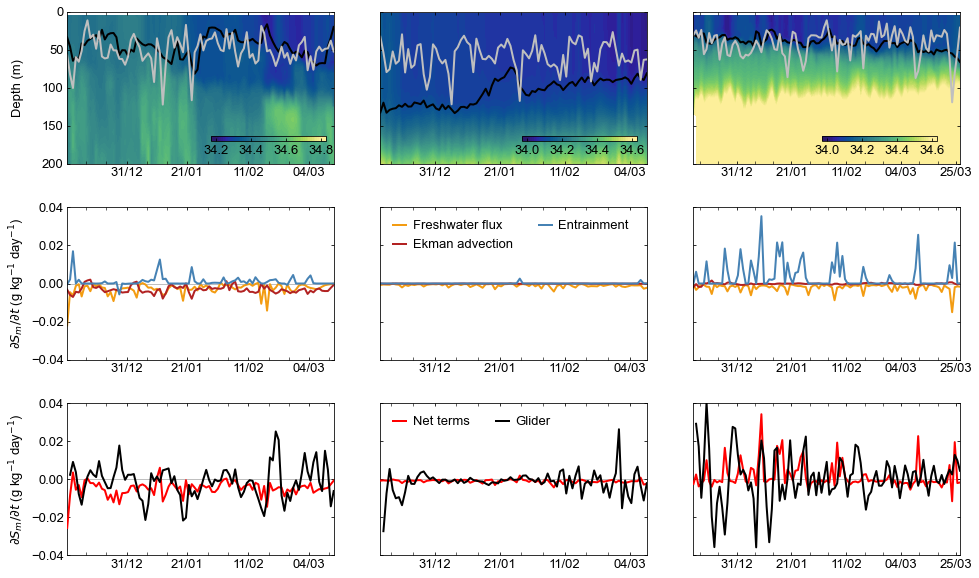

In [130]:
# set the plot
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16,10))

gs = gridspec.GridSpec(nrows=9,ncols=3)  # sets a grid of 6 rows by 4 column

fig.subplots_adjust(hspace=2, wspace=0.175)

props=dict(fontsize=12)

for i, dat in enumerate([dat_saz_1D, dat_apz_1D, dat_miz_1D]):

    # plotting the mixed layer sections
    
    ax1 = fig.add_subplot(gs[0:3, i]) # this says first 3 grid points in rows, and 2 columns i.e., (a)
    
    vmins = [34.2, 34, 34]
    vmaxs = [34.8, 34.6, 34.6]
    
    h1=ax1.contourf(dat.time.values, dat.depth, dat.salt.T, levels=np.arange(vmins[i], vmaxs[i]+0.01, 0.01), cmap=cmo.haline, extend='both')
    
    ax1.plot(dat.time, dat.mld_03 , c='k',    lw=2)
    ax1.plot(dat.time, dat.xld_est, c='0.75', lw=2)
        
    ################################
    # plotting the tendency sections
    ################################
    
    ax2 = fig.add_subplot(gs[3:6, i]) # this says first 3 grid points in rows, and 2 columns i.e., (a)

    dat['ff_dS'] = dat['dS_ff']       *86400
    dat['ek_dS'] = dat['ek_trans_dS'] *86400
    dat['en_dS'] = dat['ent_dS']      *86400
  
    ax2.plot(dat.time, dat['ff_dS'], c=orange,        lw=2, label='Freshwater flux')
    ax2.plot(dat.time, dat['ek_dS'], c='firebrick',   lw=2, label='Ekman advection')
    ax2.plot(dat.time, dat['en_dS'], c='steelblue',   lw=2, label='Entrainment')
#     ax2.plot(dat.time, dat['ga_dS'], c=green,  lw=1.25, label='Geo advection')
        
    ################################
    # plotting the tendency sections
    ################################
    
    ax3 = fig.add_subplot(gs[6:9, i]) # this says first 3 grid points in rows, and 2 columns i.e., (a)        

    dat['net_terms_dS'] = dat['ff_dS'] + dat['ek_dS'] + dat['en_dS'] 
    dat['glider_dS']    = dat['ml_s_smooth'].diff(dim='time')
    
    ax3.plot(dat.time    , dat['net_terms_dS'], label='Net terms',  c='r', lw=2, zorder=10) 
    ax3.plot(dat.time[1:], dat['glider_dS'][1:], label='Glider',    c='k', lw=2, zorder=10)        
        
    ################################
    # plotting edits
    ################################
    
    if i==0:
        ax1.set_ylabel('Depth (m)', labelpad=18)
        ax2.set_ylabel( r'$\partial S_m / \partial t$ (g kg$^{-1}$ day$^{-1}$)')
        ax3.set_ylabel( r'$\partial S_m / \partial t$ (g kg$^{-1}$ day$^{-1}$)')
        
    if i>0:
        for a in [ax1, ax2, ax3]:
            a.yaxis.set_ticklabels([])

    for a in [ax1, ax2, ax3]:
        
        a.xaxis.set_major_locator(weeks)
        a.xaxis.set_minor_locator(week)
        a.xaxis.set_major_formatter(yearsFmt)
        
        a.yaxis.set_ticks_position('both')
        a.xaxis.set_ticks_position('both')
        
#         a.grid(lw=0.5, alpha=0.5, ls='--')
        
    ax1.set_xlim(dat.time.values[0], dat.time.values[-1])
    ax2.set_xlim(dat.time.values[0], dat.time.values[-1])
    ax3.set_xlim(dat.time.values[0], dat.time.values[-1])
        
    ax1.yaxis.set_ticks([0, 50, 100, 150, 200])
    
    # legend 
    
    if i==1:
        ax1.set_ylim(200, 0)
        ax2.legend(ncol=2, loc=2, handlelength=1, handletextpad=0.5, borderpad=0.5, fontsize=13, frameon=False)
        ax3.legend(ncol=2, loc=2, handlelength=1, handletextpad=0.5, borderpad=0.5, fontsize=13, frameon=False)
    else:
        ax1.set_ylim(200, 0)
    
    # colorbars 
    
    if i==0:
        cax = fig.add_axes(([0.25, 0.7, 0.1, 0.0075]))
        cb = colorbar(mappable=h1, cax=cax, pad=0.02, extendrect=True, drawedges=False, ticks=np.arange(34, 35.2, 0.2), orientation='horizontal')
        
    if i==1:
        cax = fig.add_axes(([0.52, 0.7, 0.1, 0.0075]))
        cb = colorbar(mappable=h1, cax=cax, pad=0.02, extendrect=True, drawedges=False, ticks=np.arange(34, 35.2, 0.2), orientation='horizontal')
        
    if i==2:
        cax = fig.add_axes(([0.78, 0.7, 0.1, 0.0075]))
        cb = colorbar(mappable=h1, cax=cax, pad=0.02, extendrect=True, drawedges=False, ticks=np.arange(34, 35.2, 0.2), orientation='horizontal')
        
    ax2.set_ylim(-0.04, 0.04)
    ax3.set_ylim(-0.04, 0.04)
    
#     ax2.yaxis.set_ticks(np.arange(-0.3, 0.45, 0.15))
#     ax3.yaxis.set_ticks(np.arange(-0.3, 0.45, 0.15))
    
    ax2.plot([pd.to_datetime('2018-12-10'), pd.to_datetime('2019-03-26')], [0, 0], zorder=0, lw=1, c='0.75')
    ax3.plot([pd.to_datetime('2018-12-10'), pd.to_datetime('2019-03-26')], [0, 0], zorder=0, lw=1, c='0.75')
    

savefig('../../figures/salt_tendency_breakdown.png', dpi=300, bbox_inches='tight')

Determine the variance of the salinity from the glider obsevations and the net terms by removing the mean and trend

In [132]:
for i, dat in enumerate([dat_saz_1D, dat_apz_1D, dat_miz_1D]):

    # determine the mean
    glider_dS_mean = dat.glider_dS[1:].mean()
    
    # remove the mean 
    glider_dS_anom = dat.glider_dS[1:] - glider_dS_mean
    
    # find the trend
    X = np.arange(len(glider_dS_anom)).reshape(-1, 1)
    Y = glider_dS_anom.values.reshape(-1, 1)
    
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    
    Y_pred = linear_regressor.predict(X)  # make predictions
    
    # make xarray dataset of the trend
    # dS_pred = xr.Dataset(dict(Y_pred=('time', Y_pred.squeeze())), coords=dict(time=(["time"], glider_dS_anom.time)))
    
    # get the variance of the data minus the mean and trend
    dS_var = np.var(glider_dS_anom.values - Y_pred)
    
    print(dS_var)

7.644086672321027e-05
3.609821992895679e-05
0.00016077684738334682


In [ ]:
for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):

    # determine the mean
    terms_dS_mean = dat.net_terms_dS[1:].mean()
    
    # remove the mean 
    terms_dS_anom = dat.net_terms_dS[1:] - glider_dS_mean
    
    # find the trend
    X = np.arange(len(terms_dS_anom)).reshape(-1, 1)
    Y = terms_dS_anom.values.reshape(-1, 1)
    
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    
    Y_pred = linear_regressor.predict(X)  # make predictions
    
    # make xarray dataset of the trend
    # dS_pred = xr.Dataset(dict(Y_pred=('time', Y_pred.squeeze())), coords=dict(time=(["time"], glider_dS_anom.time)))
    
    # get the variance of the data minus the mean and trend
    dS_var = np.var(terms_dS_anom.values - Y_pred)
    
    print(dS_var)

In [ ]:
import seaborn as sns

fig, ax = subplots(1, 3, figsize=[11, 5], sharey=True)

for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):

    window=40
    
    ml_t_roll = rolling_mean(dat.ml_t_smooth, window=window)[window:-window]
    ml_s_roll = rolling_mean(dat.ml_s_smooth, window=window)[window:-window]

    T_anom = rolling_mean(dat.ml_t_smooth, 4)-ml_t_roll
    S_anom = rolling_mean(dat.ml_s_smooth, 4)-ml_s_roll
    
    alpha = gsw.alpha(rolling_mean(dat.ml_s_smooth, 4), rolling_mean(dat.ml_t_smooth, 4), 0)
    beta  = gsw.beta (rolling_mean(dat.ml_s_smooth, 4), rolling_mean(dat.ml_t_smooth, 4), 0)
    
    dT = T_anom.diff(dim='time')*alpha
    dS = S_anom.diff(dim='time')*beta
    
    R = dT/dS
    
    Tu = [math.atan(r) for r in R]
    
    Tu = np.array(Tu)
    
#    Tu, R, p = gsw.Turner_Rsubrho(dS, dT, p=0, axis=0)
    
# #     ax[i].hist(R, bins=np.arange(-7, 7.2, 0.5), facecolor=blue, zorder=10, alpha=0.6, edgecolor='0.95')
    ax[i].hist(Tu, bins=np.arange(-1.5, 1.6, 0.1), facecolor=blue, zorder=10, alpha=0.55, edgecolor='0.95', density=True)
    ax[i].set_xlim(-math.pi/2, math.pi/2)
    
    ax[i].xaxis.set_ticks([-math.pi/2, -math.pi/4, 0, math.pi/4, math.pi/2])
    ax[i].xaxis.set_ticklabels(['-$\pi$/2', '-$\pi$/4', 0, '$\pi$/4', '$\pi$/2'])
#     ax[i].grid(axis='x', zorder=0, c='0.25', ls='-')
    ax[i].plot([0,0],[0, 1.2], c='k', lw=1, alpha=0.5, ls='--')
    ax[i].set_ylim(0, 1.2)
    
    ax[i].fill_between(x=[-math.pi/2, -math.pi/4], y1=0, y2=1.2, facecolor=red, alpha=0.15)
    ax[i].fill_between(x=[ math.pi/2,  math.pi/4], y1=0, y2=1.2, facecolor=red, alpha=0.15)
    ax[i].fill_between(x=[-math.pi/4,  math.pi/4], y1=0, y2=1.2, facecolor=lightblue, alpha=0.15)
      
    sns.kdeplot(Tu, ax=ax[i], zorder=10, c=blue, lw=3)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('Turner angle')
    
ax[1].text(-1.5, 1.0, 'Anti- \n compensated', fontsize=13)
ax[1].text( 0.1, 1.0, 'Compensated', fontsize=13)

ax[1].text(-0.3, 1.25, 'Sal dom.',  fontsize=13, color=blue)
ax[1].text(-1.7, 1.25, 'Temp dom.',  fontsize=13, color=red)
ax[1].text( 0.85, 1.25, 'Temp dom.', fontsize=13, color=red)

ax[0].text(-1.5, 1.13, 'a', fontweight='bold')
ax[1].text(-1.5, 1.13, 'b', fontweight='bold')
ax[2].text(-1.5, 1.13, 'c', fontweight='bold')
    
# ax[0].set_ylabel('Probability')

savefig('../../figures/turner_angle.png', dpi=300, bbox_inches='tight')

## Mixed layer eddy calculations and pie charts

We determine the mixed layer buoyancy from the average buoyancy across the mixed layer.

In [84]:
# get the mean buoyancy within the mixed layer
for dat in [dat_saz_1D, dat_apz_1D, dat_miz_1D]:

    xb=[]
    
    for i, m in enumerate(np.round(dat['mld_03'].astype(int))):
        
        xb += dat.buoyancy.sel(depth=slice(5, m-5)).mean(dim='depth').values[i],
    
    dat['ml_b'] = (('time'), xb)

Determine the lateral buoyancy bouyancy gradient from the interpolated values of buoyancy to a common grid. The grid used here is 2 km. 

<ipython-input-231-f8bec1beae3e>:106: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax.pie(sizes,


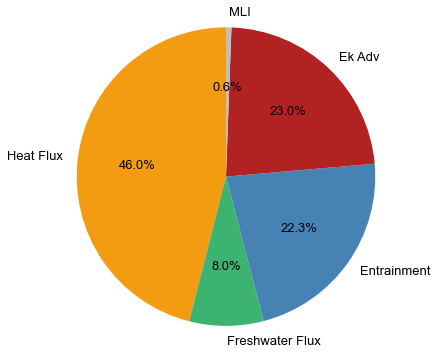

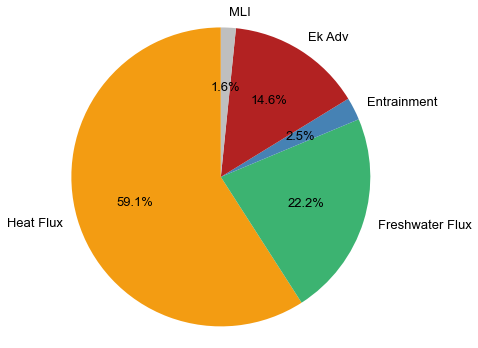

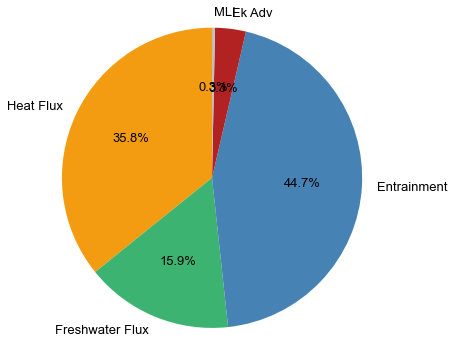

In [231]:
sites = ['saz', 'pfz', 'miz']

for i, dat in enumerate([dat_saz_1D, dat_apz_1D, dat_miz_1D]):
    
    if i==0:
        dat_raw=dat_saz
    if i==1:
        dat_raw=dat_apz
    if i==2:
        dat_raw=dat_miz
        
    dat_raw['buoyancy'] = -9.81*(dat_raw['density']-1025)/1025
        
    xb=[]
    xt=[]
    xs=[]
    
    for c, m in enumerate(np.round(dat_raw['mld_03'].astype(int))):
        
        xb += dat_raw.buoyancy.sel(depth=slice(10, m-5)).mean(dim='depth').values[c],        
        xt += dat_raw.temp.sel(depth=slice(10, m-5)).mean(dim='depth').values[c],
        xs += dat_raw.salt.sel(depth=slice(10, m-5)).mean(dim='depth').values[c],
    
    dat_raw['ml_s'] = (('time'), xs)
    dat_raw['ml_t'] = (('time'), xt)
    dat_raw['ml_b'] = (('time'), xb)
    
    for c, val in enumerate(dat_raw.ml_b):
            
        if val<-0.027:
            dat_raw['ml_b'][c] = dat_raw['ml_b'][c-1] 
        
    # determin the along-track distance 
    d = gsw.distance(dat_raw.lon.values, dat_raw.lat.values)
    d_sum = np.append(0, np.cumsum(d))
    
    # make a new grid from cumulative sum of the distances
    new_grid = np.arange(0, d_sum[-1], 6000)
    
    t = date2num(dat_raw.time.values)
    
    # interpolate the mixed layer buoyancy and depth to the new grid
    ml_b_6km = scipy.interpolate.griddata(d_sum, dat_raw['ml_b'].values,   new_grid)
    mld_6km  = scipy.interpolate.griddata(d_sum, dat_raw['mld_03'].values, new_grid)
    time_6km = scipy.interpolate.griddata(d_sum, t,                        new_grid)
    
    # find the buoyancy gradients
    ml_bx_6km = np.diff(ml_b_6km)/6000
    
    # Submesoscale MLI equivalent heat flux
    
    #set the parameters for the equivalent heat flux equation
    
    c     = 0.06         # emperically defined coefficient
    bx    = ml_bx_6km    # buoyancy gradient
    H     = mld_6km[1:]  # mixed layer depth
    f     = gsw.f(dat_raw.lat).mean().values # coriolis freq
    Cp    = 3850         # specific heat capacity
    rho0  = 1027         # density
    alpha = gsw.alpha(dat_raw.ml_s, dat_raw.ml_t, 0).mean().values # thermal expansion coeff
    g     = 9.81         # gravitational acceleration
    
    # determine the MLI flux
    
    mli = c * ( (bx**2 * H**2)/np.abs(f) ) * ( (Cp*rho0)/(alpha*g) )
    
    dat_raw['mli'] = (('time'), scipy.interpolate.griddata(time_6km[:-1], mli, t))
    
    ###################
    
    # convert the tendency units of C/s and psu/s to W m-2
    
    hm     = dat['mld_03'] # mixed layer depth
    beta   = -gsw.beta(dat.ml_s_smooth, dat.ml_t_smooth, 0).mean() # haline contraction coeff
    alpha  = gsw.alpha(dat.ml_s_smooth, dat.ml_t_smooth, 0).mean() # haline contraction coeff

    dat['hf_wm2']   = dat['dT_hf']       * (rho0*Cp*hm) # heat flux
    dat['en_t_wm2'] = dat['ent_dT']      * (rho0*Cp*hm) # entrainment
    dat['ek_t_wm2'] = dat['ek_trans_dT'] * (rho0*Cp*hm) # ekman adv
    
    dat['ff_wm2']   = dat['dS_ff']       * (rho0*Cp*hm*(beta/alpha)) # freshwater flux
    dat['ek_s_wm2'] = dat['ek_trans_dS'] * (rho0*Cp*hm*(beta/alpha)) # entrainment
    dat['en_s_wm2'] = dat['ent_dS']      * (rho0*Cp*hm*(beta/alpha)) # ekman adv
    
    dat['mli_wm2']  = dat_raw['mli'].interp_like(dat)
    
    # now plot the pie chart
    
    labels = 'Heat Flux', 'Freshwater Flux', 'Entrainment', 'Ek Adv', 'MLI'
    clrs   = orange, 'mediumseagreen', 'steelblue', 'firebrick', '0.75'
    
    hf   = np.nanmean(np.abs(dat['hf_wm2']))
    ff   = np.nanmean(np.abs(dat['ff_wm2']))
    
    en = np.nanmean(np.abs(dat['en_t_wm2']) + np.abs(dat['en_s_wm2']))
    ek = np.nanmean(np.abs(dat['ek_t_wm2']) + np.abs(dat['ek_s_wm2']))
    
    sm   = np.nanmean(np.abs(dat['mli_wm2']))
    
    total = hf+ff+en+ek+sm   
    
    sizes = [hf/total, ff/total, en/total, ek/total, sm/total]
    
    fig,ax=subplots(figsize=[6,6])
    
    ax.pie(sizes, 
           labels=labels, 
           autopct='%1.1f%%', 
           colors=clrs,
           startangle=90)
    
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
#     ax.legend(ncol=6, bbox_to_anchor=(0, 1))
    
    savefig('../../figures/pie_'+str(sites[i])+'_labels.png', dpi=300, bbox_inches='tight')

#### Conversion of tendency units to W m-2

What are the equivalent heat flux mean contributions for each term?

In [230]:
for i, dat in enumerate([dat_saz_1D, dat_apz_1D, dat_miz_1D]):
    
    print('-----')
    
    print('heat flux: ' + str(np.round(np.nanmean(dat['hf_wm2'] .values))) + ' std ' + str(np.round(np.nanstd(dat['hf_wm2'] .values))))
    print('fresh flx: ' + str(np.round(np.nanmean(dat['ff_wm2'] .values))) + ' std ' + str(np.round(np.nanstd(dat['ff_wm2'] .values))))
    print('sms mli  : ' + str(np.round(np.nanmean(dat['mli_wm2'].values))) + ' std ' + str(np.round(np.nanstd(dat['mli_wm2'].values))))
    
    en = dat['en_t_wm2'] + dat['en_s_wm2'] # substract the salinity equiv. W m-2 from the temperature as neg salinity means freshening
    ek = dat['ek_t_wm2'] + dat['ek_s_wm2'] # substract the salinity equiv. W m-2 from the temperature as neg salinity means freshening
    
    print('entrainmt: ' + str(np.round(np.nanmean(en.values))) + ' std ' + str(np.round(np.nanstd(en.values))))
    print('ekmanadvn: ' + str(np.round(np.nanmean(ek.values))) + ' std ' + str(np.round(np.nanstd(ek.values))))

-----
heat flux: 140.0 std 81.0
fresh flx: 25.0 std 26.0
sms mli  : 2.0 std 6.0
entrainmt: -69.0 std 111.0
ekmanadvn: -7.0 std 4.0
-----
heat flux: 146.0 std 57.0
fresh flx: 55.0 std 41.0
sms mli  : 4.0 std 7.0
entrainmt: -6.0 std 39.0
ekmanadvn: -27.0 std 14.0
-----
heat flux: 118.0 std 77.0
fresh flx: 55.0 std 63.0
sms mli  : 1.0 std 2.0
entrainmt: -155.0 std 287.0
ekmanadvn: 7.0 std 9.0
